# Modularity analysis

In [1]:
from slfmri import io as slio
from slfmri.lib.stats.ttest import onesample_ttest_perm
from slfmri.lib.stats.corr import r_to_t
from sympy import Symbol, solve
from custom_module import *
import pickle
import re

# prep filepath
code = 'E'
suffix = 'bp001010'
mask_path = '../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz'
iput_pm = slio.PathMan('../Results/UNCCH_CAMRI/140_Pacellation')
oput_pm = slio.PathMan('../Results/UNCCH_CAMRI/150_CommunityDetection')

parcels_path = iput_pm(f'./Rat_CAMRI_400um_ATLAS-filtered_{code}.nii.gz')

# load data
parcels_nii = nib.load(parcels_path)
mask_nii = nib.load(mask_path)
mask_idx = np.nonzero(mask_nii.dataobj)

# load dataset
pipe = pn.Pipeline('../', verbose=0)
pipe.set_package(0)

## Generate connectivity matrix

In [2]:
def ttest(data, model):
    from slfmri import filter as slflt
    from scipy import stats
    predicted, coef = slflt.linear_regression(data, model, method='svd', return_beta=True)

    dof = model.shape[0] - model.shape[1]
    mse = np.square(predicted.sum(-1) - data).sum(-1) / float(dof)
    se = np.sqrt((mse * np.concatenate([np.linalg.inv(np.dot(model.T, model)).diagonal()[:, np.newaxis]], axis=-1)).T)

    t = coef.copy()
    if model.shape[-1] == 1:
        # one sample t-test
        t -= t.mean()  # against population mean
    t[se == 0] = 0
    t[np.nonzero(se)] /= se[np.nonzero(se)]
    p = 2 * (1 - stats.t.cdf(abs(t), df=dof))
    return coef, t, p

def onesample_ttest_perm(data, pval=0.05, nperm=5000, twosided=False):
    from tqdm.notebook import tqdm
    model = np.ones([data.shape[1], 1])
    b, t_o, p_o = ttest(data, model)

    tmax = np.zeros(nperm)
    tmin = np.zeros(nperm)
    for p in tqdm(range(nperm)):
        model_perm = np.c_[model, np.random.choice([1, -1], data.shape[-1], replace=True)]
        b_p, t_p, p_p = ttest(data, model_perm)
        tmax[p] = t_p[:, 1].max()
        tmin[p] = t_p[:, 1].min()
    if twosided:
        pp_perm = np.zeros(data.shape[0])
        np_perm = pp_perm.copy()
        for i in range(data.shape[0]):
            pp_perm[i] = (tmax >= t_o[i, 0]).astype(int).sum() / nperm
            np_perm[i] = (tmin <= t_o[i, 0]).astype(int).sum() / nperm
        t_o[(pp_perm >= pval / 2) & (np_perm >= pval / 2)] = 0
    else:
        p_perm = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            p_perm[i] = (tmax >= t_o[i, 0]).astype(int).sum() / nperm
        t_o[p_perm >= pval] = 0
    b[t_o == 0] = 0 
    return b, t_o

In [3]:
# Load temporal profiles from above data and generate numpy array for statistics
connmat_path = oput_pm(f'connmat_{code}.pkl')
if os.path.exists(connmat_path):
    with open(connmat_path, 'rb') as f:
        values = pickle.load(f)
else:
    dcode_dr = '40A' # load random-segmented and standardized dataset
    dset_dr = pipe.get_dset(dcode_dr)

    parcels_data = np.asarray(parcels_nii.dataobj)

    fname_ptrn = r'^sub-.*_run-(?P<time>[0-9]{1})_cap.nii.gz$'
    n_tests  = int(parcels_data.max())
    n_data = len(dset_dr)
    n_repeats = 3

    values = np.zeros([int((n_tests * (n_tests - 1)) / 2), int(n_data / n_repeats), n_repeats])
    tested_subj = dict()
    subj_id = 0
    for _, finfo in tqdm(dset_dr):
        time = int(re.match(fname_ptrn, finfo.Filename).groups()[0])
        subj = finfo.Subject
        if subj not in tested_subj.keys():
            tested_subj[subj] = subj_id
            subj_id += 1

        # Load data then calculate correlation
        picked_data = np.asarray(nib.load(finfo.Abspath).dataobj)
        ts = np.zeros([n_tests, picked_data.shape[-1]])

        for i, idx in enumerate(range(1, n_tests + 1)):
            ts[i, :] = picked_data[parcels_data == idx].mean(0)
        data = np.tril(np.corrcoef(ts), k=-1)
        data = data[np.nonzero(data)]

        # Fisher's transform
        data = np.arctanh(data)
        values[:, tested_subj[subj], time-1] = data
    with open(connmat_path, 'wb') as f:
        pickle.dump(values, f)
        
# group connectivity topology
s_data = values.mean(-1)
perm_path = oput_pm(f'connmat_sig_{code}.npy')
if os.path.exists(perm_path):
    sig_b = np.load(perm_path)
else:
    sig_b = onesample_ttest_perm(s_data)[0]
    np.save(perm_path, sig_b)
sig_b = np.tanh(sig_b)

# threshold the connectivity matrix based on the r table
t, p = r_to_t(sig_b, 450)
sig_b[p > 0.05] = 0

## Check distribution of the edges

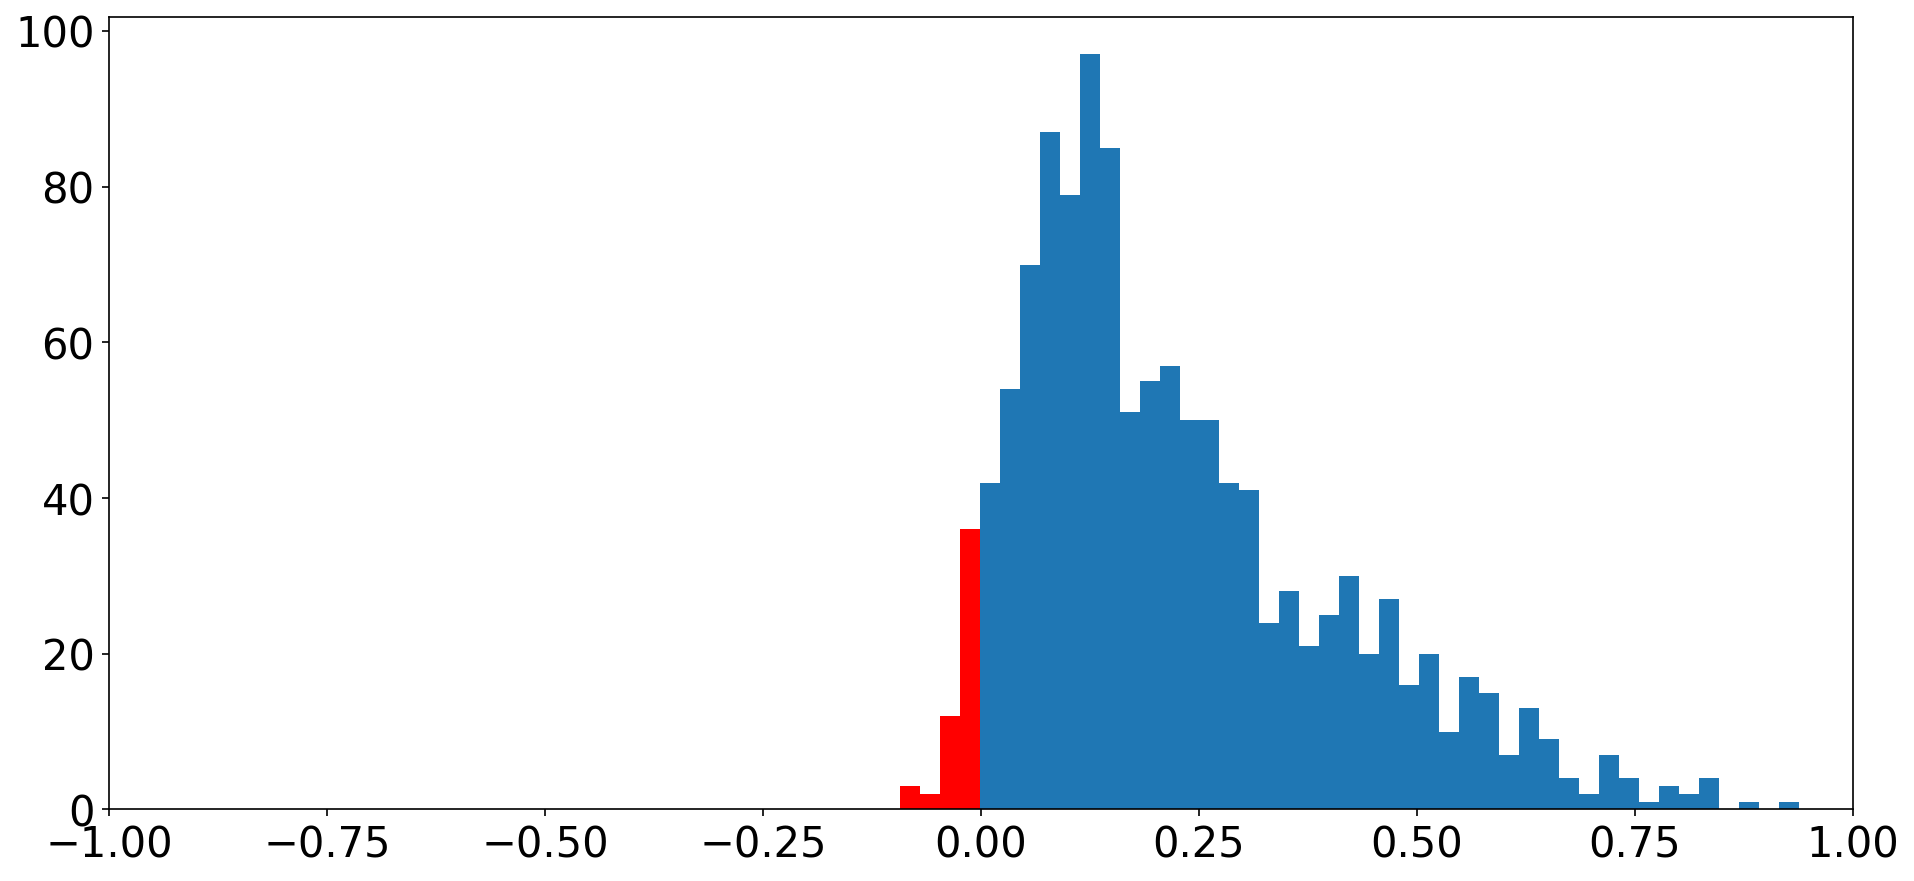

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[15, 7], dpi=150)

# vals = thr_matrix.values[np.tril(np.ones(thr_matrix.shape).astype(bool), k=-1)]
# N, bins, patches = ax.hist(vals[np.nonzero(vals)], bins=50)
N, bins, patches = ax.hist(s_data.mean(-1), bins=50)
plt.xlim(-1, 1)
plt.xticks(size = 20)
plt.yticks(size = 20)

for i, p in enumerate(patches):
    if i < 4:
        p.set_facecolor('r')
#     if i == 4:
#         p.set_facecolor('k')

# Group-level analysis - one-sample t-test (permute)

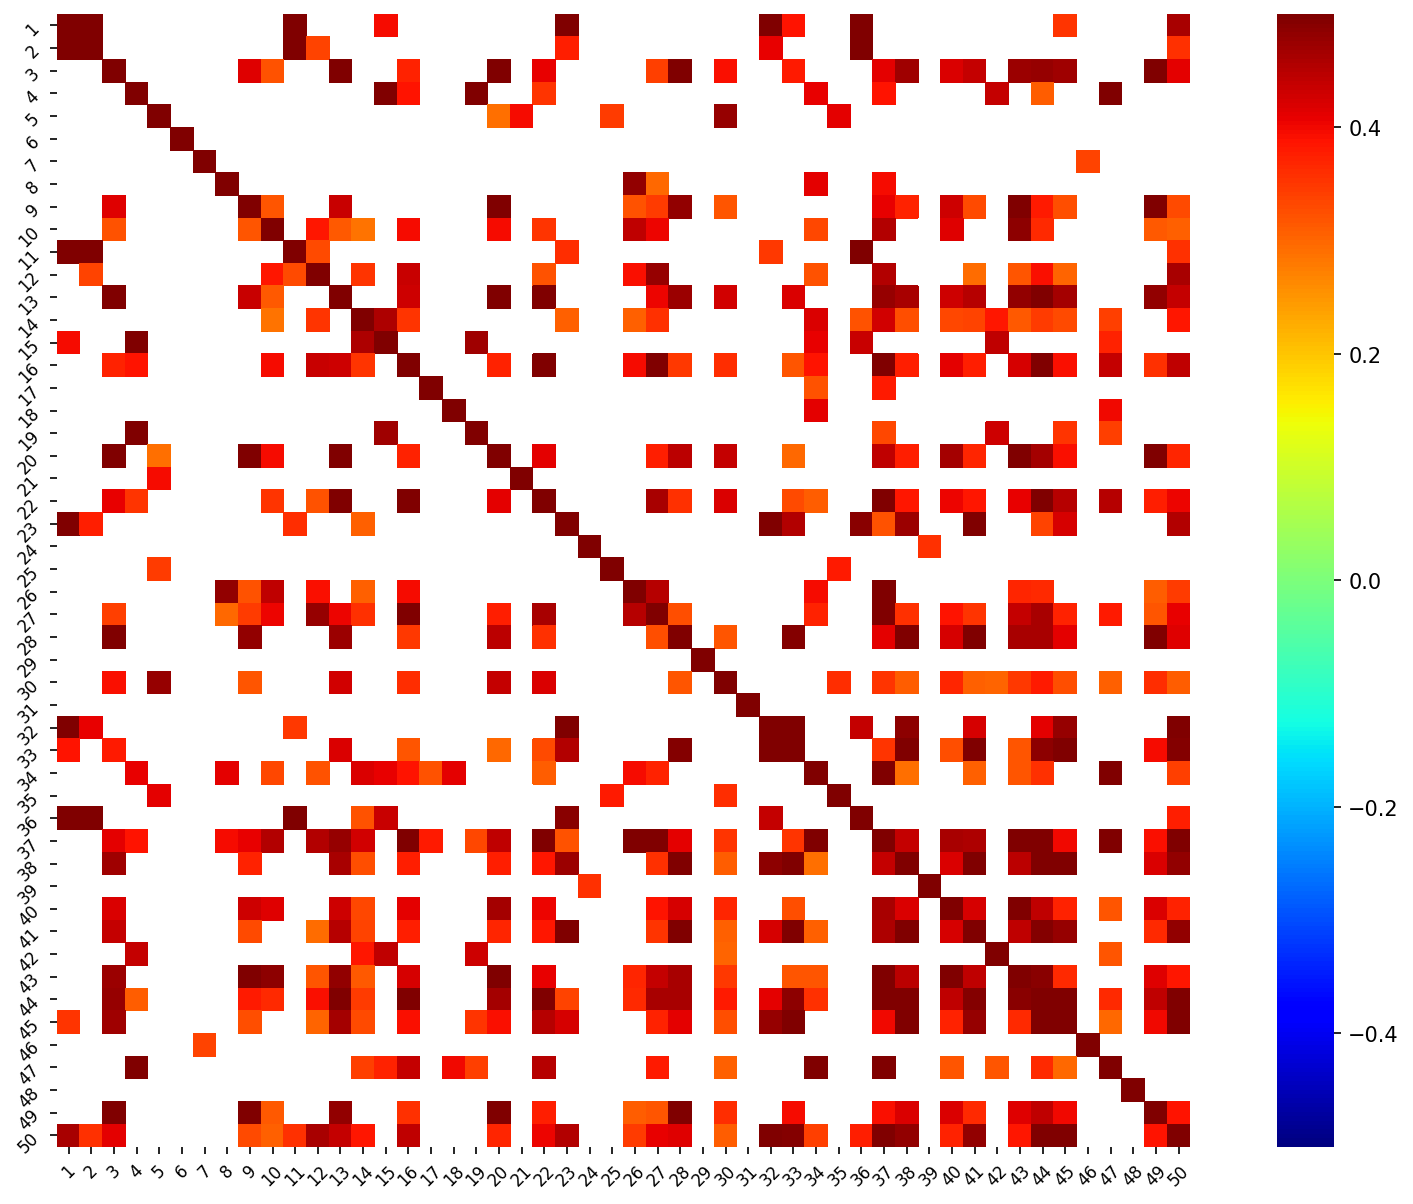

In [4]:
# visualization
label_fontsize = 8

n = Symbol('n')
eq = n*(n-1) - s_data.shape[0]*2
num_col = [s for s in solve(eq) if s > 0][0]

# Check positive connectivity matrix
matrix_mask = np.tril(np.ones([num_col] * 2), k=-1)
output_matrix = matrix_mask * 0
output_matrix[np.nonzero(matrix_mask)] = np.tanh(sig_b[..., 0])
output_matrix = fill_upperhalf(output_matrix)

# remove zero values for plotting
thr_matrix = output_matrix.copy()
thr_matrix[thr_matrix == 0] = np.nan
thr_matrix.columns += 1
thr_matrix.index += 1

fig, ax = plt.subplots(1, 1, figsize=(15,10), dpi=150)
sns.heatmap(thr_matrix, ax=ax, vmin=-0.5, vmax=0.5, cmap='jet')
ax.set_aspect(1)   # result shows 'all positive'

_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=label_fontsize, rotation=45)
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=label_fontsize, rotation=45)

In [5]:
mat = thr_matrix.values
mat = mat[np.tril_indices_from(mat, k=-1)]
mat = np.nan_to_num(mat)

avr_conn = mat[np.nonzero(mat)].mean()
num_edge = mat[np.nonzero(mat)].shape[0]
print(f'avr_conn={avr_conn}\nnum_edges = {num_edge/mat.shape[0]}')

avr_conn=0.41669641041557
num_edges = 0.2546938775510204


# Heirarchical clustering and visualization

In [8]:
import matplotlib
from matplotlib import patches
from matplotlib.colors import to_rgb

from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from slfmri import io as slio
import copy

In [9]:
matplotlib.rcParams['lines.linewidth'] = 4
metric = 'euclidean'
method = 'ward'
tick_fontsize = 70
thr_matrix[~thr_matrix.notnull()] = 0
thr_matrix[thr_matrix == 1] = 0

# set thresholding distance for clustering
color_thr = 0.25
# Classify the cluster, the colors must have lenght larger then the length of the groups
ofname = oput_pm(f'Label-{metric}-{method}_{suffix}')

sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=[80, 15], dpi=300)
Z = linkage(thr_matrix, method, metric=metric)
dend = dendrogram(Z, ax=ax, orientation='top', color_threshold=color_thr*max(Z[:,2]))
yt = plt.yticks(fontsize=tick_fontsize)
xt = plt.xticks(fontsize=tick_fontsize)

/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


In [10]:
# correlation / weighted
hier_groups = [7, 4, 8, 6, 5, 15, 5]
hier_comcon = [1, 1, 1, 1, 1,  1, 1]
hier_colors = [
    'lime',
    'greenyellow',
    'green',
    
    'mediumblue',
    'mediumpurple',
    'plum',
    'purple'
         ]

hier_colors += ['gray'] * (len(hier_groups) - len(hier_colors))

In [11]:
set_link_color_palette(hier_colors)
matplotlib.rcParams['lines.linewidth'] = 5
sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=[80, 15], dpi=300)
Z = linkage(thr_matrix, method, metric=metric)
dend = dendrogram(Z, ax=ax, orientation='top', color_threshold=color_thr*max(Z[:,2]))
yt = plt.yticks(fontsize=70)
xt = plt.xticks(fontsize=70)
minx, maxx = ax.get_xlim()
ax.plot([minx, maxx], [color_thr*max(Z[:,2]), color_thr*max(Z[:,2])], 'r--')

# Applied threshold
print(f'Applied threshold: {color_thr*max(Z[:,2])}')

/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


Applied threshold: 1.8651980136957784


/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:34: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


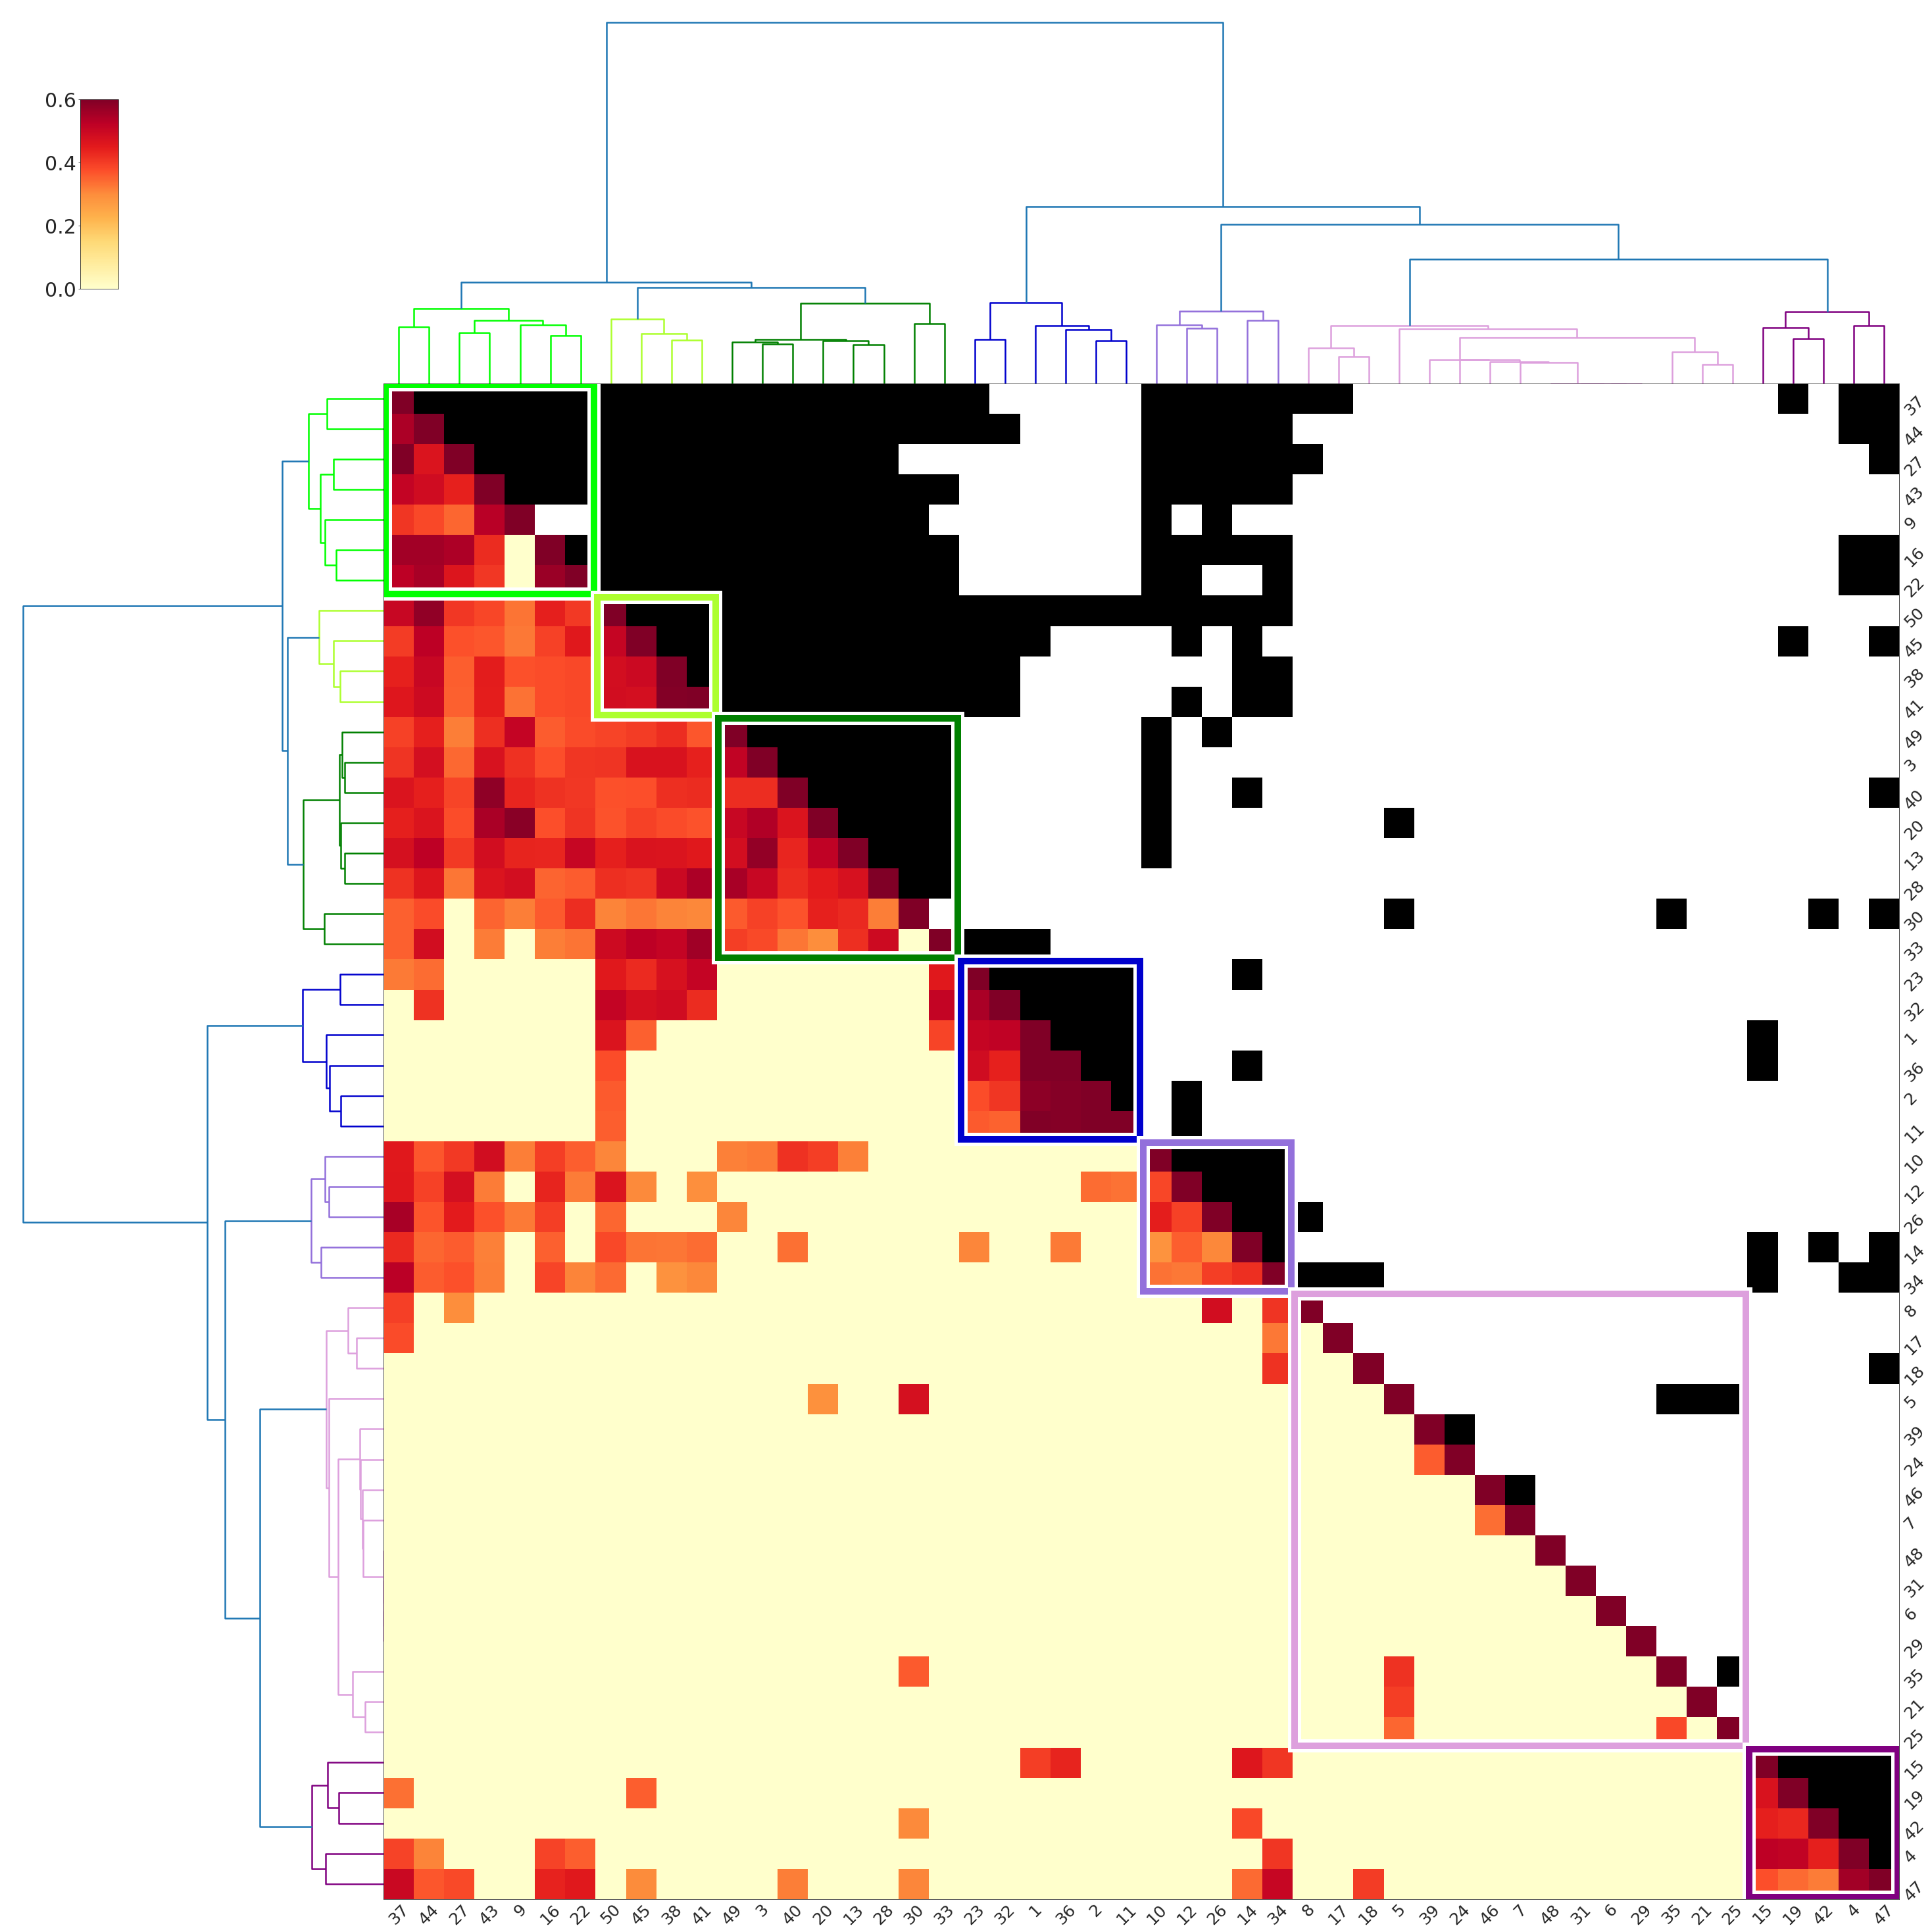

In [12]:
# Color mapping for dendrogram
set_link_color_palette(hier_colors)
matplotlib.rcParams['lines.linewidth'] = 2.5
sns.set_style('white')

# If true, update color scheme on label file
update_color_scheme = True

# prep figure and gridspec
figsize = np.array([40, 40])
fig = plt.figure(figsize=figsize, 
                 constrained_layout=False)
widths = [0.04, 0.02, 0.04, 0.02, 0.08, 0.8]
heights = [0.05, 0.1, 0.05, 0.8]
linewidth = 10

gs = fig.add_gridspec(nrows=4, ncols=6, 
                      left=0, right=1,
                      bottom=0, top=1,
                      wspace=0, hspace=0,
                      width_ratios=widths, 
                      height_ratios=heights)

# prep plot axes
ax_top_dend = fig.add_subplot(gs[:3, 5])
ax_lft_dend = fig.add_subplot(gs[3, :5])
ax_heatmap = fig.add_subplot(gs[3, 5])
cax = fig.add_subplot(gs[1, 1])

ax_top_dend.axis('off')
ax_lft_dend.axis('off')

# heirarchical clustering
Z = linkage(thr_matrix.values, method, metric=metric)

# dendrogram
dend_top = dendrogram(Z, ax=ax_top_dend, 
                      orientation='top', 
                      color_threshold=color_thr*max(Z[:,2]))
dend_lft = dendrogram(Z, ax=ax_lft_dend, 
                      orientation='left', 
                      color_threshold=color_thr*max(Z[:,2]))
ax_lft_dend.invert_yaxis()


df_1 = pd.DataFrame(thr_matrix.values + np.diag(np.ones(thr_matrix.shape[0]))).loc[dend_top['leaves'], 
                                                                                   dend_top['leaves']]
lower_mask = np.tril(np.ones(thr_matrix.shape))
df_2 = (df_1 != 0).astype(float)
df_2.values[np.nonzero(lower_mask)] = np.nan

hm = ax_heatmap.imshow(df_1, vmin=0, vmax=0.6, cmap='YlOrRd')
pm = ax_heatmap.imshow(df_2, vmin=0, vmax=1, cmap='gray_r')

fig.colorbar(hm, cax=cax, orientation='vertical')
cax.tick_params(axis='y', labelsize=30, pad=3)
cax.yaxis.tick_left()

ax_heatmap.yaxis.tick_right()
ax_heatmap.set_xticks(np.arange(0, thr_matrix.shape[0]))
ax_heatmap.set_yticks(np.arange(0, thr_matrix.shape[0]))
ax_heatmap.set_xticklabels([str(idx + 1) for idx in dend_top['leaves']], fontsize=25, rotation=45)
ax_heatmap.set_yticklabels([str(idx + 1) for idx in dend_top['leaves']], fontsize=25, rotation=45)
ax_heatmap.tick_params(axis='both', which='both', length=0)

colors = copy.copy(hier_colors)
groups = copy.copy(hier_groups)
comcon = copy.copy(hier_comcon)

# Draw squares for the cluster
for i, gid in enumerate(groups):
    if comcon[i]:
        cid = int(i)
        while cid >= len(colors):
            cid = cid-len(colors)
        color = colors[cid].split('_')[0]
        pch_size = gid-0.1
        pch_loc = sum(groups[:i]) - 0.45
        pch = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=20, color='white')
        pcp = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=10, color=color)
        ax_heatmap.add_patch(pch)
        ax_heatmap.add_patch(pcp)
    else:
        colors.insert(i, 'C0')
        c = 'C0'
        pch_size = gid-0.1
        pch_loc = sum(groups[:i]) - 0.45
        pch = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=linewidth, color='white')
        pcp = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=4, color=c)
        ax_heatmap.add_patch(pch)
        ax_heatmap.add_patch(pcp)

if update_color_scheme:
    atlas = slio.Atlas(parcels_path)
    labels = np.array(dend_top['leaves']) + 1

    hier_dict = {c:[] for c in colors}
    counter = 0

    for i, n_comp in enumerate(groups):
        for _ in range(n_comp):
            c = colors[i]
            hier_dict[c].append(labels[counter])
            counter += 1

    for c, list_idx in hier_dict.items():
        for idx in list_idx:
            rgb = to_rgb(c.split('_')[0])
            atlas.cmap[idx] = rgb
    atlas.save_label(ofname)

In [13]:
hier_dict

{'lime': [37, 44, 27, 43, 9, 16, 22],
 'greenyellow': [50, 45, 38, 41],
 'green': [49, 3, 40, 20, 13, 28, 30, 33],
 'mediumblue': [23, 32, 1, 36, 2, 11],
 'mediumpurple': [10, 12, 26, 14, 34],
 'plum': [8, 17, 18, 5, 39, 24, 46, 7, 48, 31, 6, 29, 35, 21, 25],
 'purple': [15, 19, 42, 4, 47]}

## Modularity analysis

### Permutation test to identify significant components

- Modularity analysis that Yihong group using.
- Algorithm to maximize modularity

In [14]:
import networkx as nx
import pickle
from community import best_partition, modularity, generate_dendrogram, partition_at_level

def matrix_to_graph(matrix, side='upper', random=False):
    matrix = matrix.copy()
    nodes = list(matrix.columns)
    if side == 'upper':
        m_arr = np.triu(matrix.values, k=-1)
    elif side == 'lower':
        m_arr = np.tril(matrix.values, k=-1)
    else:
        raise Exception
    g = nx.Graph()
    g.add_nodes_from(nodes)
    for i, j in np.transpose(np.nonzero(m_arr)):
        r = matrix.loc[nodes[i], nodes[j]]
        d = 1-r
        if random:
            node1, node2 = np.sort(np.random.choice(matrix.columns, 2))
            while g.get_edge_data(node1, node2) is not None:
                node1, node2 = np.sort(np.random.choice(matrix.columns, 2))
        else:
            node1, node2 = nodes[i], nodes[j]
        g.add_edge(node1, node2, weight=r, distance=d)
    return g

In [15]:
g = matrix_to_graph(abs(thr_matrix))
print(nx.info(g))

mod_path = oput_pm(f'modularity-iter5000_{code}.pkl')
if os.path.exists(mod_path):
    with open(mod_path, 'rb') as f:
        mod_dict = pickle.load(f)
else:
    mod_dict = dict(partition=[], modularity=[], dendrogram=[])
    for i in tqdm(range(5000)):
        part = best_partition(g, randomize=True)
        mod_dict['partition'].append(part)
        mod_dict['modularity'].append(modularity(part, g))
        mod_dict['dendrogram'].append(generate_dendrogram(g, randomize=True))
    mod_dict = pd.DataFrame(mod_dict)
    with open(mod_path, 'wb') as f:
        pickle.dump(mod_dict, f)
        
argmax = mod_dict.sort_values(by='modularity')[::-1].index[0]
best_set = mod_dict.loc[argmax, :]

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 312
Average degree:  12.4800


# Reordered but keep the module structure

In [16]:
modules = dict()
for idx, m in best_set.partition.items():
    if m not in modules.keys():
        modules[m] = []
    modules[m].append(idx)
modules

{0: [1, 2, 11, 23, 32, 36, 50],
 1: [3, 9, 13, 20, 22, 28, 30, 33, 38, 40, 41, 43, 44, 45, 49],
 2: [4, 8, 10, 12, 14, 15, 16, 17, 18, 19, 26, 27, 34, 37, 42, 47],
 3: [5, 21, 25, 35],
 4: [6],
 5: [7, 46],
 6: [24, 39],
 7: [29],
 8: [31],
 9: [48]}

In [17]:
hier_groups = [7, 4, 8, 6, 5, 15, 5]

gid = 0
hier_clusters = {i:[] for i in range(len(hier_groups))}
for i, rid in enumerate(dend['leaves']):
    hier_clusters[gid].append(rid+1)
    if len(hier_clusters[gid]) == hier_groups[gid]:
        gid += 1

hier_clusters

{0: [37, 44, 27, 43, 9, 16, 22],
 1: [50, 45, 38, 41],
 2: [49, 3, 40, 20, 13, 28, 30, 33],
 3: [23, 32, 1, 36, 2, 11],
 4: [10, 12, 26, 14, 34],
 5: [8, 17, 18, 5, 39, 24, 46, 7, 48, 31, 6, 29, 35, 21, 25],
 6: [15, 19, 42, 4, 47]}

In [18]:
# Reorganization to preserve both structure identified from modularity-based and clustering-based
colm = [# module 0
        11, 2, 36, 1, 32, 23, # c3
        50, # c1 
        # module 1
        45, 38, 41, # c1
        33, 30, 28, 13, 20, 40, 3, 49, # c2
        44, 43, 9, 22, # c0
        # module 2
        37, 27, 16,    # c0
        10, 12, 26, 14, 34, # c4
        47, 4, 42, 19, 15, # c6
        8, 17, 18, # c5
        # module 3
        5, 35, 21, 25, # c5
        # module 6
        39, 24, # c5
        # module 5
        46, 7, # c5
        # module 9
        48, # c5
        # module 8
        31, # c5
        # module 4
        6, # c5
        # module 7
        29] # c5


# correlation / weighted
mod_groups = [6, 4, 8, 7, 5, 5, 3, 4, 
              2, 2, 1, 1, 1, 1] # not meaningful due to the no between connection and small cluster-size
mod_comcon = [1, 1, 1, 1, 1, 1, 0, 0, 
              0, 0, 0, 0, 0, 0]

mod_colors = ['mediumblue','greenyellow','green','lime','mediumpurple','purple','plum']

new_mat = thr_matrix.loc[colm, colm]
diag_mask = np.nonzero(np.eye(new_mat.shape[0]))
new_mat.values[diag_mask] = 1

In [19]:
list_colors = ['royalblue', 'limegreen', 'palevioletred', 'darkviolet', 'lightgrey']
cm = matplotlib.colors.LinearSegmentedColormap.from_list('module', list_colors, N=len(list_colors))
ofname = oput_pm(f'Label-modules_{suffix}')

matplotlib.rcParams['lines.linewidth'] = 10

sns.set_style('white')
figsize = np.array([33, 30])
fig = plt.figure(figsize=figsize, 
                 constrained_layout=False,
                 dpi=300)
widths = [0.05, 0.95, 0.07, 0.03]
heights = [0.05, 0.55, 0.40]
linewidth = 10

gs = fig.add_gridspec(nrows=3, ncols=4, 
                      left=0, right=1,
                      bottom=0, top=1,
                      wspace=0, hspace=0,
                      width_ratios=widths, 
                      height_ratios=heights)
ax_lft_mod = fig.add_subplot(gs[1:, 0])
ax_top_mod = fig.add_subplot(gs[0, 1])
ax_heatmap = fig.add_subplot(gs[1:, 1])
cax = fig.add_subplot(gs[2, 3])

ax_top_mod.axis('off')
ax_lft_mod.axis('off')

modules = [7, 15, 16, 4, 8]
mod_labels = []
for i, m in enumerate(modules):
    mod_labels.append([i] * m)
mod_labels = np.concatenate(mod_labels)[:, np.newaxis]

lower_mask = np.tril(np.ones(new_mat.shape))
bi_mat = (new_mat != 0).astype(float)
bi_mat.values[np.nonzero(lower_mask)] = np.nan

hm = ax_heatmap.imshow(new_mat, vmin=0, vmax=0.6, cmap='YlOrRd')
pm = ax_heatmap.imshow(bi_mat, vmin=0, vmax=1, cmap='gray_r')
ax_heatmap.set_aspect(1)

ax_heatmap.yaxis.tick_right()
ax_heatmap.set_xticks(np.arange(0, new_mat.shape[0]))
ax_heatmap.set_yticks(np.arange(0, new_mat.shape[0]))
ax_heatmap.set_xticklabels(colm, fontsize=35, rotation=45)
ax_heatmap.set_yticklabels(colm, fontsize=35, rotation=45)
ax_heatmap.tick_params(axis='both', which='both', length=0)

fig.colorbar(hm, cax=cax, orientation='vertical')
cax.tick_params(axis='y', labelsize=40, pad=3)
cax.yaxis.tick_right()

aspect_ratio = (new_mat.shape[0] / 0.95) * 0.045

ax_top_mod.imshow(mod_labels.T, cmap=cm)
ax_top_mod.set_aspect(aspect_ratio)
ax_lft_mod.imshow(mod_labels, cmap=cm)
ax_lft_mod.set_aspect(1/aspect_ratio)

colors = copy.copy(mod_colors)
groups = copy.copy(mod_groups)
comcon = copy.copy(mod_comcon)

for i, g in enumerate(groups):
    if comcon[i]:
        cid = int(i)
        while cid >= len(colors):
            cid = cid-len(colors)
        c = colors[cid].split('_')[0]
        pch_size = g-0.1
        pch_loc = sum(groups[:i]) - 0.45
        pch = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=20, color='white', alpha=0.8)
        pcp = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=10, color=c, alpha=0.5)
        ax_heatmap.add_patch(pch)
        ax_heatmap.add_patch(pcp)
    else:
        colors.insert(i, None)
        
        
module_dict = dict()
module_dict = {c:[] for c in list_colors}
counter = 0

for i, n_comp in enumerate(modules):
    for _ in range(n_comp):
        c = list_colors[i]
        module_dict[c].append(colm[counter])
        counter += 1

imp_clusts = hier_dict['green'] + hier_dict['mediumblue'] + hier_dict['purple']
for c, list_idx in module_dict.items():
    for idx in list_idx:
        rgb = to_rgb(c.split('_')[0])
        atlas.cmap[idx] = rgb
        if idx not in imp_clusts:
            atlas._conf[idx]['Opacity'] = 0.5
atlas.save_label(ofname)

In [20]:
module_dict

{'royalblue': [11, 2, 36, 1, 32, 23, 50],
 'limegreen': [45, 38, 41, 33, 30, 28, 13, 20, 40, 3, 49, 44, 43, 9, 22],
 'palevioletred': [37,
  27,
  16,
  10,
  12,
  26,
  14,
  34,
  47,
  4,
  42,
  19,
  15,
  8,
  17,
  18],
 'darkviolet': [5, 35, 21, 25],
 'lightgrey': [39, 24, 46, 7, 48, 31, 6, 29]}

In [ ]:
[39, 24, 46, 7, 48, 31, 6, 29]

## Hub detection

In [21]:
def get_centtable(matrix):
    thr_matrix = matrix.copy()
    thr_matrix[~thr_matrix.notnull()] = 0
    thr_matrix[thr_matrix == 1] = 0

    # normalized connectivity strength
    norm_pos_connstr = thr_matrix.sum(0) / (matrix.shape[0] - 1)

    # normalized connectivity diversity
    connection_diversity = {i:None for i in range(1, 51)}
    for color, module in module_dict.items():
        for node in module:
            si_u = matrix.loc[node, module].values.sum() / (matrix.shape[0] - 1)
            hi = (-1 / np.log(len(module_dict))) * si_u * np.log(si_u)
            connection_diversity[node] = hi

    # density
    conndens = thr_matrix.astype(bool).sum(0)

    # betweeness centrality - weight and nonweight
    thr_g = matrix_to_graph(thr_matrix)
    betcent_w = nx.betweenness_centrality(thr_g, weight='distance')
    betcent_b = nx.betweenness_centrality(thr_g)

    # closeness centrality
    clocent_w = nx.closeness_centrality(thr_g, distance='distance')
    clocent_b = nx.closeness_centrality(thr_g)

    cent_table = pd.DataFrame(dict(ConnStr = norm_pos_connstr,
                                   Betnessw = betcent_w,
                                   CloCentw = clocent_w,
                                   ConnDiv = connection_diversity))
    return cent_table

Normalized out-strength (source), in-strength (sink), and in + out strength (global) hub regions of the voxel-wise connectome were computed at the percolation threshold. To map the anatomical extension of hub-like areas and obtain a “hubness” index for individual voxels, for each metric, we first iteratively identified and labeled the highest-ranking voxels at increasing percentile threshold (50th to 99th). The obtained information was then combined into a single frequency (%) map by plotting the number of times a voxel was labeled as hub across varying percentile thresholds. We limited the visualization to the nodes that were classified as hubs at least 90% of the time, with the aim to capture top strength nodes and produce heatmaps where hotter colors indicate hub-like voxels corresponding to highest percentile ranking. This approach ultimately led to the final representation of nodes exceeding the 94% strength percentile for all hub categories.   {2020 coletta}

In [22]:
module_dict = dict()
module_dict = {c:[] for c in list_colors}
counter = 0

for i, n_comp in enumerate(modules):
    for _ in range(n_comp):
        c = list_colors[i]
        module_dict[c].append(colm[counter])
        counter += 1

In [23]:
thr_mat = thr_matrix.copy()

thr_set = np.arange(5, 25) # 50th to 90th
hubness = np.zeros([thr_set.shape[0], thr_mat.shape[0], 4])

for i, thr in enumerate(tqdm(thr_set[::-1])):
    cent_table = get_centtable(thr_mat).fillna(0)
    
    for c in cent_table.columns:
        selected = cent_table[[c]].sort_values(by=c)[::-1][:thr].index
        for node in selected:
            if c == 'ConnStr':
                hubness[i, node-1, 0] = 1
            elif c == 'Betnessw':
                hubness[i, node-1, 1] = 1
            elif c == 'CloCentw':
                hubness[i, node-1, 2] = 1
            elif c == 'ConnDiv':
                hubness[i, node-1, 3] = 1
            
hubs = np.nonzero((hubness.sum(-1) >= 1).astype(int).mean(0) > 0.95)[0] + 1

/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [24]:
hubs

array([ 3,  5, 13, 16, 20, 28, 30, 34, 37, 44, 45, 50])

In [25]:
cent_table_path = oput_pm(f'CentralityTable_{code}.xlsx')
# if not os.path.exists(cent_table_path):
thr_mat = thr_matrix.copy()
cent_table = get_centtable(thr_mat).fillna(0)
cent_table.to_excel(cent_table_path)
# else:
#     cent_table = pd.read_excel(cent_table_path, index_col=0)
    
cent_table

/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


ConnStr  Betnessw  CloCentw   ConnDiv
1   0.091010  0.008503  0.745696  0.113373
2   0.066935  0.000850  0.667899  0.104883
3   0.170150  0.000000  0.895202  0.166213
4   0.079372  0.009354  0.749154  0.111237
5   0.039311  0.066327  0.623111  0.054959
6   0.000000  0.000000  0.000000  0.000000
7   0.006885  0.000000  0.030799  0.021298
8   0.032399  0.000000  0.653946  0.069041
9   0.139570  0.000000  0.845316  0.146579
10  0.128706  0.000000  0.831042  0.099357
11  0.065400  0.000000  0.664996  0.103343
12  0.114080  0.005102  0.809622  0.102195
13  0.178096  0.000000  0.928145  0.168490
14  0.136542  0.014456  0.841252  0.120975
15  0.071624  0.021259  0.693931  0.098715
16  0.204112  0.000000  0.994375  0.125027
17  0.014349  0.000000  0.630938  0.037838
18  0.016584  0.000000  0.581621  0.042239
19  0.049894  0.003401  0.698097  0.083601
20  0.175789  0.015306  0.926599  0.164688
21  0.008111  0.000000  0.433380  0.024263
22  0.186701  0.000000  0.970203  0.150953
23  0.113574  0.004252  0.786653  0.100041
24  0.007308  0.000000  0.031794  0.022336
25  0.014857  0.000000  0.425593  0.038856
26  0.104652  0.003401  0.813908  0.115351
27  0.188648  0.000000  0.942877  0.124895
28  0.161998  0.000850  0.881016  0.165605
29  0.000000  0.000000  0.000000  0.000000
30  0.146640  0.115646  0.899726  0.139987
31  0.000000  0.000000  0.000000  0.000000
32  0.103820  0.001701  0.763795  0.101024
33  0.154216  0.001701  0.857032  0.145358
34  0.145990  0.034864  0.859990  0.148381
35  0.023601  0.000000  0.559016  0.041597
36  0.079559  0.011905  0.710409  0.109434
37  0.265071  0.145408  1.114359  0.153646
38  0.193741  0.005102  0.961127  0.163365
39  0.007308  0.000000  0.031794  0.022336
40  0.176309  0.000000  0.928774  0.158846
41  0.198574  0.013605  0.973735  0.162347
42  0.047328  0.008503  0.667834  0.081583
43  0.201675  0.003401  0.969021  0.164040
44  0.245235  0.005952  1.073041  0.168029
45  0.208660  0.010204  0.993837  0.159884
46  0.006885  0.000000  0.030799  0.021298
47  0.120418  0.015306  0.851795  0.130044
48  0.000000  0.000000  0.000000  0.000000
49  0.168161  0.000000  0.880146  0.161984
50  0.246652  0.095238  1.064675  0.094860

In [26]:
hubness_score = pd.DataFrame(hubness.mean(0))
hubness_score.columns = ['Strength', 'Betweeness', 'Closeness', 'Diversity']

hubness_score

Strength  Betweeness  Closeness  Diversity
0       0.00        0.55       0.00       0.10
1       0.00        0.00       0.00       0.00
2       0.55        0.00       0.50       1.00
3       0.00        0.60       0.00       0.05
4       0.00        1.00       0.00       0.00
5       0.00        0.00       0.00       0.00
6       0.00        0.00       0.00       0.00
7       0.00        0.00       0.00       0.00
8       0.25        0.00       0.20       0.50
9       0.15        0.00       0.10       0.00
10      0.00        0.00       0.00       0.00
11      0.05        0.35       0.00       0.00
12      0.70        0.00       0.65       1.00
13      0.20        0.80       0.15       0.20
14      0.00        0.95       0.00       0.00
15      1.00        0.00       1.00       0.30
16      0.00        0.00       0.00       0.00
17      0.00        0.00       0.00       0.00
18      0.00        0.20       0.00       0.00
19      0.60        0.85       0.60       1.00
20      0.00        0.00       0.00       0.00
21      0.75        0.00       0.90       0.60
22      0.00        0.30       0.00       0.00
23      0.00        0.00       0.00       0.00
24      0.00        0.00       0.00       0.00
25      0.00        0.25       0.05       0.15
26      0.80        0.00       0.75       0.25
27      0.45        0.00       0.45       1.00
28      0.00        0.00       0.00       0.00
29      0.35        1.00       0.55       0.40
30      0.00        0.00       0.00       0.00
31      0.00        0.10       0.00       0.00
32      0.40        0.05       0.30       0.45
33      0.30        1.00       0.35       0.55
34      0.00        0.00       0.00       0.00
35      0.00        0.70       0.00       0.00
36      1.00        1.00       1.00       0.65
37      0.85        0.40       0.80       0.90
38      0.00        0.00       0.00       0.00
39      0.65        0.00       0.70       0.70
40      0.90        0.75       0.95       0.85
41      0.00        0.50       0.00       0.00
42      0.95        0.15       0.85       0.95
43      1.00        0.45       1.00       1.00
44      1.00        0.65       1.00       0.75
45      0.00        0.00       0.00       0.00
46      0.10        0.90       0.25       0.35
47      0.00        0.00       0.00       0.00
48      0.50        0.00       0.40       0.80
49      1.00        1.00       1.00       0.00

In [27]:
hubness_df = dict(label = [], metric = [], centrality = [])

for i, cols in hubness_score.iterrows():
    for j in range(4):
        if j == 0:
            c = cols.Strength
            m = 'FC strength'
        elif j == 1:
            c = cols.Betweeness
            m = 'betweenness'
        elif j == 2:
            c = cols.Closeness
            m = 'closeness'
        else:
            c = cols.Diversity
            m = 'diversity'
        hubness_df['label'].append(i+1)
        hubness_df['metric'].append(m)
        hubness_df['centrality'].append(c*100)
hubness_df = pd.DataFrame(hubness_df)
hubness_df

label       metric  centrality
0        1  FC strength         0.0
1        1  betweenness        55.0
2        1    closeness         0.0
3        1    diversity        10.0
4        2  FC strength         0.0
..     ...          ...         ...
195     49    diversity        80.0
196     50  FC strength       100.0
197     50  betweenness       100.0
198     50    closeness       100.0
199     50    diversity         0.0

[200 rows x 3 columns]

[Text(0, 0.0, '0'),
 Text(0, 20.0, '20'),
 Text(0, 40.0, '40'),
 Text(0, 60.0, '60'),
 Text(0, 80.0, '80'),
 Text(0, 100.0, '100'),
 Text(0, 120.0, '120')]

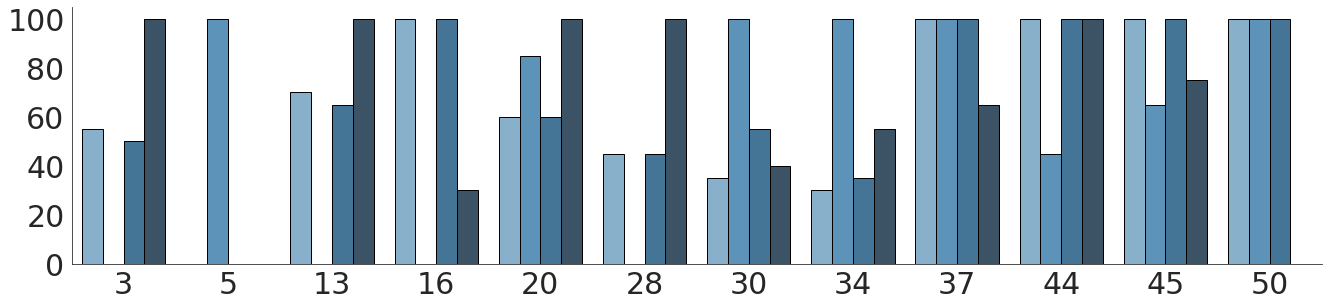

In [28]:
g = sns.catplot(data=hubness_df.query('label in @hubs'), 
                x='label', y='centrality', hue='metric',
                palette="Blues_d", kind='bar', edgecolor='k', legend=False)
lb_size = 30
tl_size = 30
g.fig.set_figwidth(20)
g.fig.set_figheight(4)

g.ax.set_xlabel('',fontsize = lb_size)
g.ax.set_ylabel('',fontsize = lb_size)

g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=tl_size)
g.ax.set_yticklabels(g.ax.get_yticklabels(), fontsize=tl_size)

# g.ax.set_ylim(0, 1.5)
# g.ax.set_yticks([0, 0.5, 1, 1.5])
# change_width(g.ax, .2)

In [29]:
hubs

array([ 3,  5, 13, 16, 20, 28, 30, 34, 37, 44, 45, 50])

- connstr high: 3, 13, 16, 20, 28, 37, 44, 45, 50
- Betweenness high : 5, 30, 34
- both, high: 16, 37, 44, 45, 50

## Rich-club Structure

Rich-club organization is characterized by the tendency of the highly connected network gubs that are densely interconnected. To define the rich-club structure in a weighted network, we first calculate the nodal strength of each node (i.e. the sum of the strength of the existing conenctions), and computed the rich-club coefficient as follow (Colizza et al. 2006)

In [31]:
def nodal_str(corr_matrix, pos=False):
    if isinstance(corr_matrix, pd.DataFrame):
        node_id = corr_matrix.columns
        mat = corr_matrix.values
    elif isinstance(corr_matrix, np.ndarray):
        mat = corr_matrix.copy()
    if pos:
        mat[mat < 0] = 0
    else:
        mat = abs(mat)
    mat[np.nonzero(np.eye(mat.shape[0]))] = 0
    
    return mat.sum(0)
    

def richclub_coef(corr_matrix, s, pos=False):
    if isinstance(corr_matrix, pd.DataFrame):
        node_id = corr_matrix.columns
        mat = corr_matrix.values
    elif isinstance(corr_matrix, np.ndarray):
        mat = corr_matrix.copy()
    
    if pos:
        mat[mat < 0] = 0
    else:
        mat = abs(mat)
    mat[np.nonzero(np.eye(mat.shape[0]))] = 0
        
    nodal_str = mat.sum(0)
    flt = np.nonzero(nodal_str >= s)[0]
    
    conns = mat[flt][:, flt]
    
    w_s = conns.sum()
    e_s = np.nonzero(conns)[0].shape[0]
    mat = np.tril(mat, k=-1)
    w_r = mat.flatten()[np.argsort(mat.flatten())[::-1][:e_s]].sum()
    if not w_r:
        return 0
    return w_s / w_r

def gen_random_mat(corr_matrix):
    if isinstance(corr_matrix, pd.DataFrame):
        node_id = corr_matrix.columns
        mat = corr_matrix.values
    elif isinstance(corr_matrix, np.ndarray):
        mat = corr_matrix.copy()
    
    mask = np.nonzero(np.tril(np.ones(mat.shape), k=-1))
    degrees = mat[mask].copy()
    np.random.shuffle(degrees)
    
    rand_mat = np.zeros(mat.shape)
    rand_mat[mask] = degrees
    rand_mat += rand_mat.T
    rand_mat[np.nonzero(np.eye(rand_mat.shape[0]))] = 1
    return rand_mat

In [34]:
from scipy.stats import t
from slfmri import filter as slflt

mat = thr_matrix.copy()
nstr = nodal_str(mat)

n_iter = 5000
pos = False

list_s = np.linspace(0, np.sort(nstr)[-1], 100)
rc_path = oput_pm(f'richclub_iter_{code}.pkl')

if os.path.exists(rc_path):
    with open(rc_path, 'rb') as f:
        rc_orig, rc_rand = pickle.load(f)
else:
    rc_orig = np.zeros(list_s.shape[0])
    rc_rand = np.zeros([n_iter, list_s.shape[0]])

    for i, s in tqdm(enumerate(list_s), total=len(list_s)):
        for j in range(n_iter):
            rand_mat = gen_random_mat(mat)
            rc_rand[j, i] = richclub_coef(rand_mat, s)
        rc_rand = np.array(rc_rand)
        rc_orig[i] = richclub_coef(mat, s)
    with open(rc_path, 'wb') as f:
        pickle.dump((rc_orig, rc_rand), f)

tval = np.zeros(rc_orig.shape)
mask = np.nonzero(rc_rand.std(0))
tval[mask] = (rc_orig[mask] - rc_rand.mean(0)[mask]) / rc_rand.std(0)[mask]
model = slflt.polynomial_feature(list_s, 10)
model /= model.max(0)

fitted = slflt.linear_regression(rc_rand.mean(0)[np.newaxis, :], model)
rc_rand_avr = fitted.sum(-1)[0]

rc_norm = np.ones(rc_orig.shape)
mask = np.nonzero(rc_rand.mean(0))
rc_norm[mask] = rc_orig[mask] / rc_rand.mean(0)[mask]
rc_norm[rc_norm == 1] = np.nan

# Identify most significant s
pval = t.sf(abs(tval), len(rc_orig) - 1)
pval[pval == 0] = 1
pval[:20] = 1

significant = (pval < (0.05 / len(rc_orig)))

sig_s = list_s[np.argmin(np.log(pval))]
sig_p = pval[np.argmin(np.log(pval))]

nstr = nodal_str(mat)
mask = np.nonzero(nstr > sig_s)
print('Identified RichClub structure')
for idx, connstr in dict(zip(mask[0], nstr[mask])).items():
    print(f'  [{idx+1}]: {connstr}')
    
# get most significant condition as rich-club structure.
rich_club_path = oput_pm(f'RichClub_model_{code}.nii.gz')
if not os.path.exists(rich_club_path):
    rich_club = np.zeros(parcels_nii.shape)
    for idx in mask[0]:
        rich_club[np.nonzero(np.asarray(parcels_nii.dataobj) == idx+1)] = 1
    rc_nii = nib.Nifti1Image(rich_club, mask_nii.affine)
    rc_nii.header['sform_code'] = 0
    rc_nii.header['qform_code'] = 1
    rc_nii.to_filename(rich_club_path)
else:
    rc_nii = nib.load(rich_club_path)
    rich_club = np.asarray(rc_nii.dataobj)

Identified RichClub structure
  [16]: 10.001484713993564
  [37]: 12.988496402978637
  [38]: 9.49331368410761
  [41]: 9.730128340204512
  [43]: 9.882051653032514
  [44]: 12.01651250555837
  [45]: 10.224336336554478
  [50]: 12.085967678616305


In [37]:
sig_p

1.963921523475512e-110

pval = 1.963921523475512e-110


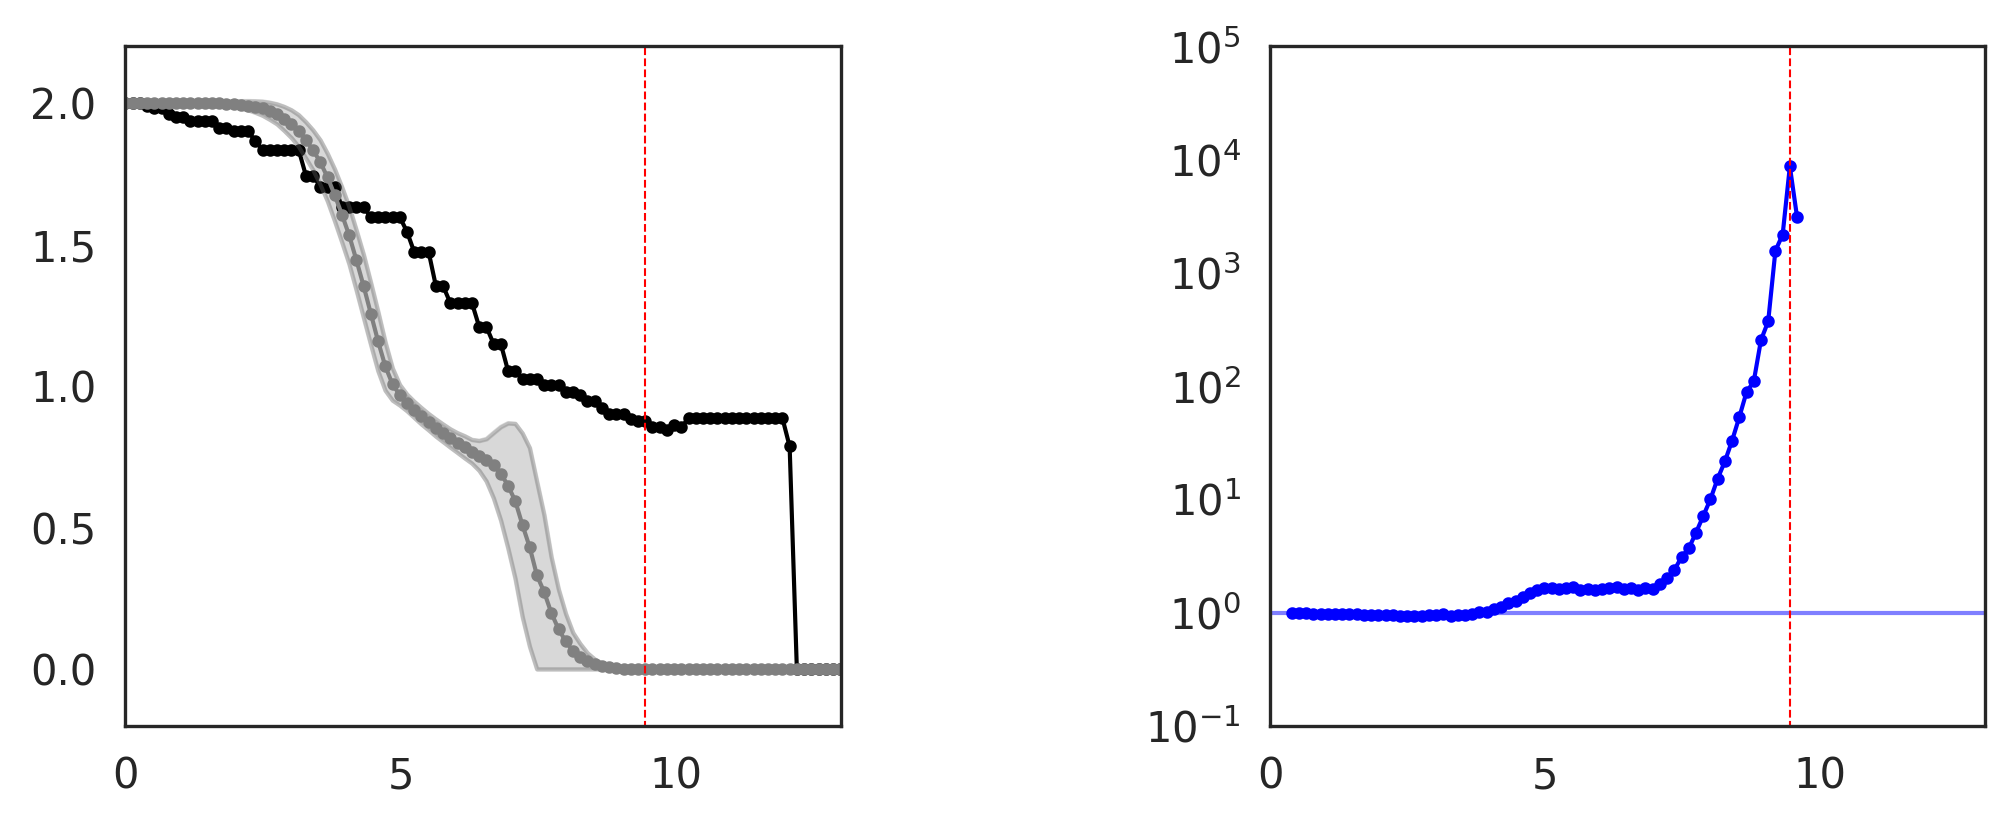

In [77]:
fig, ax = plt.subplots(1, 2, figsize=[8, 3], dpi=300) #, sharex=True)


err_top = rc_rand.mean(0) + rc_rand.std(0)
err_bottom = rc_rand.mean(0) - rc_rand.std(0)
err_top[err_bottom <= 0] += err_bottom[err_bottom <= 0] 
err_bottom[err_bottom <= 0] = 0
lw = 1
ms = 2

ax[0].plot(list_s, rc_orig, '-ok', markersize=ms, linewidth=lw)
ax[0].plot(list_s, rc_rand.mean(0), '-o', color='gray', markersize=ms, linewidth=lw)
ax[0].plot(list_s, err_top, color='gray', alpha=0.3, linewidth=lw)
ax[0].plot(list_s, err_bottom, color='gray', alpha=0.3, linewidth=lw)
ax[0].plot([sig_s, sig_s], [-1, 3], '--', color='r', linewidth=0.5)
ax[0].set_ylim(-0.2, 2.2)
ax[0].set_xlim(0, 13)
ax[0].fill_between(list_s, err_top, err_bottom, color='gray', alpha=0.3)

ax[1].plot([-1, 16], [1, 1], color='blue', alpha=0.5, linewidth=lw)
ax[1].semilogy(list_s, rc_norm, '-ob', markersize=ms, linewidth=lw)
ax[1].plot([sig_s, sig_s], [0, 10**7], '--', color='r', linewidth=0.5)
ax[1].set_ylim([10**-1., 10**5])
print(f'pval = {sig_p}')
ax[1].set_xlim(0, 13)

plt.subplots_adjust(wspace=0.6)
# plt.tight_layout()

In [26]:
mask[0]

array([15, 36, 37, 40, 42, 43, 44, 49])

In [53]:
# Merge RichClub and Hubs into image
rnh_path = oput_pm(f'RichClub_with_Hubs_{code}.nii.gz')
# if not os.path.exists(rnh_path):

for idx in hubs:
    print(idx)
    if idx-1 not in mask[0]:
        rich_club[np.nonzero(np.asarray(parcels_nii.dataobj) == idx)] = 2
    else:
        rich_club[np.nonzero(np.asarray(parcels_nii.dataobj) == idx)] = 1
rc_nii = nib.Nifti1Image(rich_club, mask_nii.affine)
rc_nii.header['sform_code'] = 0
rc_nii.header['qform_code'] = 1
rc_nii.to_filename(rnh_path)
# else:
#     rc_nii = nib.load(rnh_path)

3
5
13
16
20
28
30
34
37
44
45
50


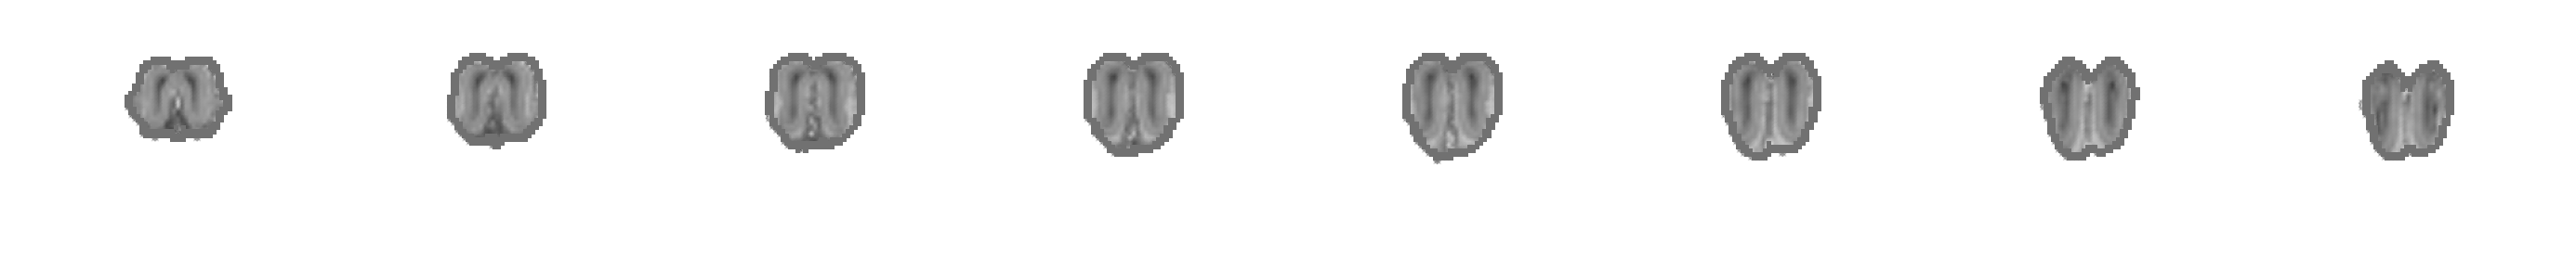

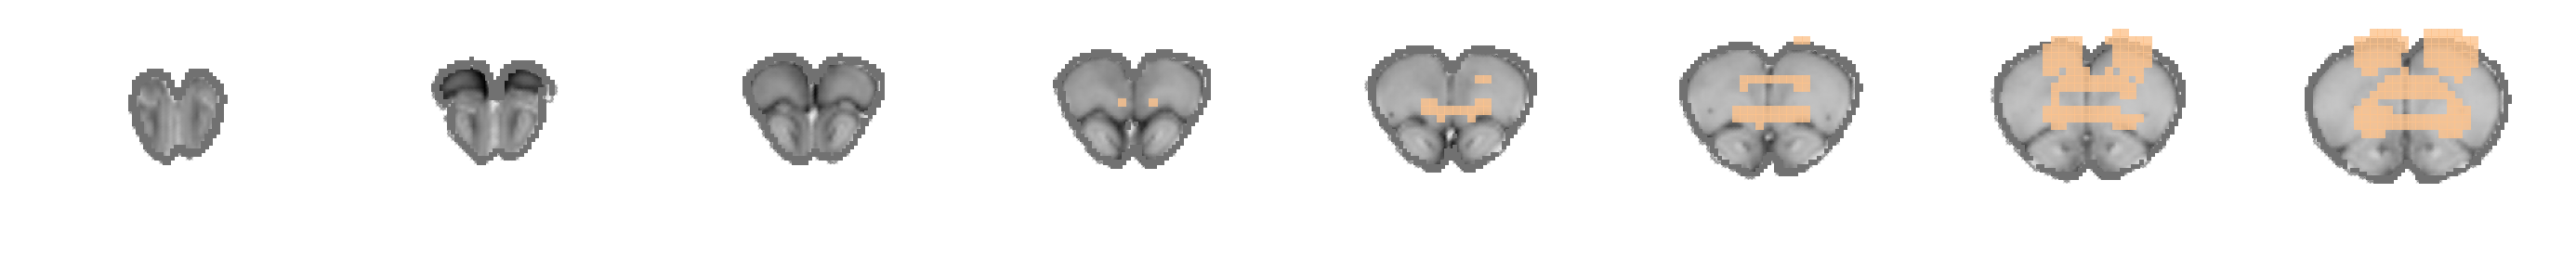

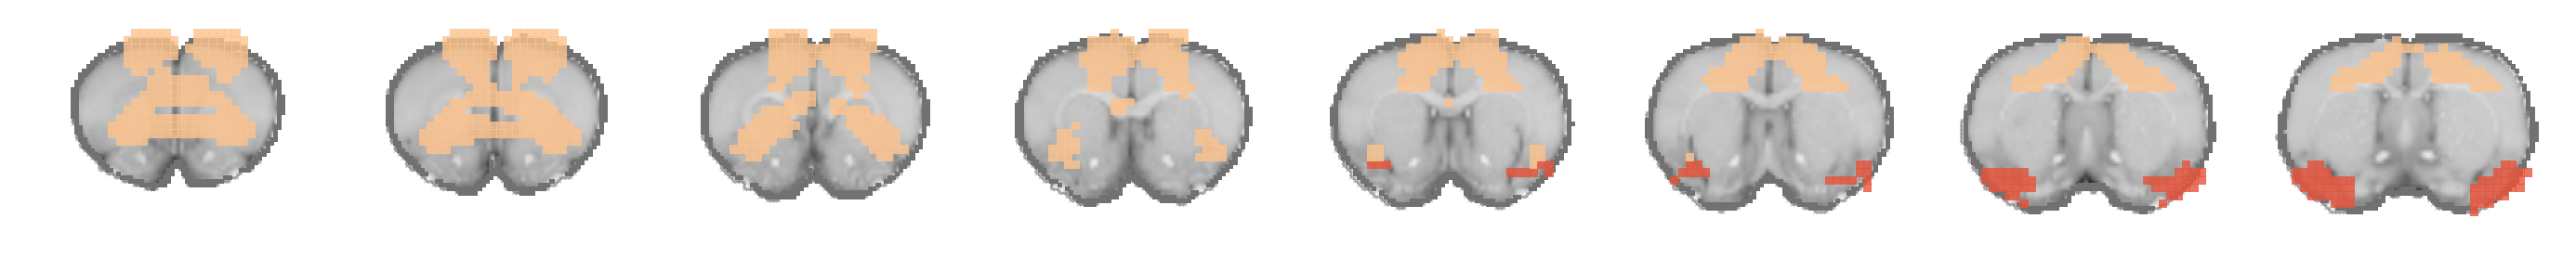

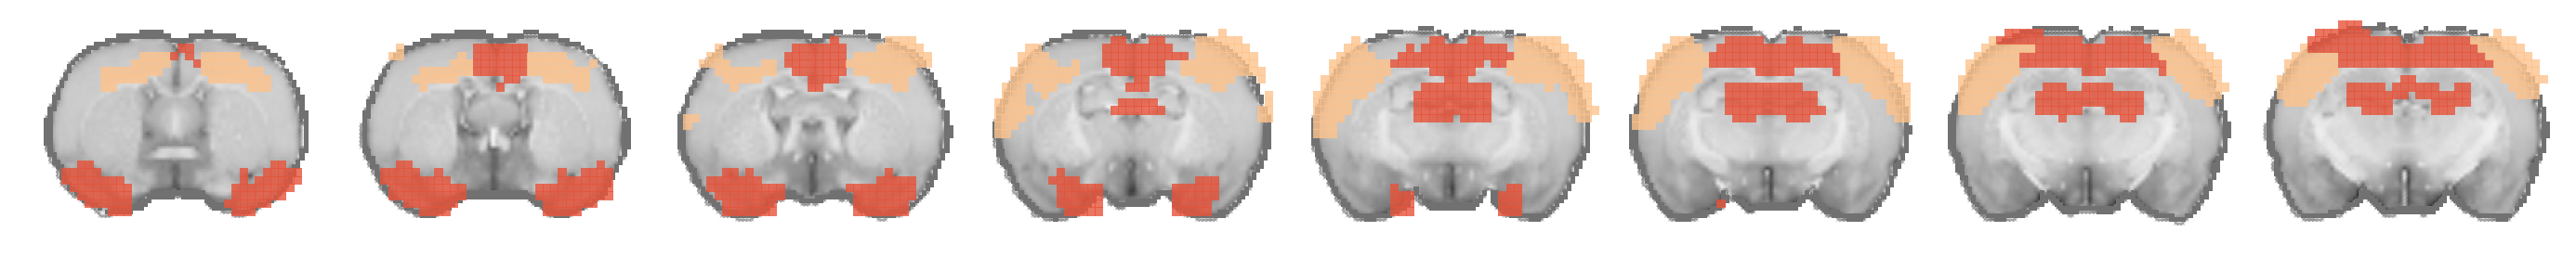

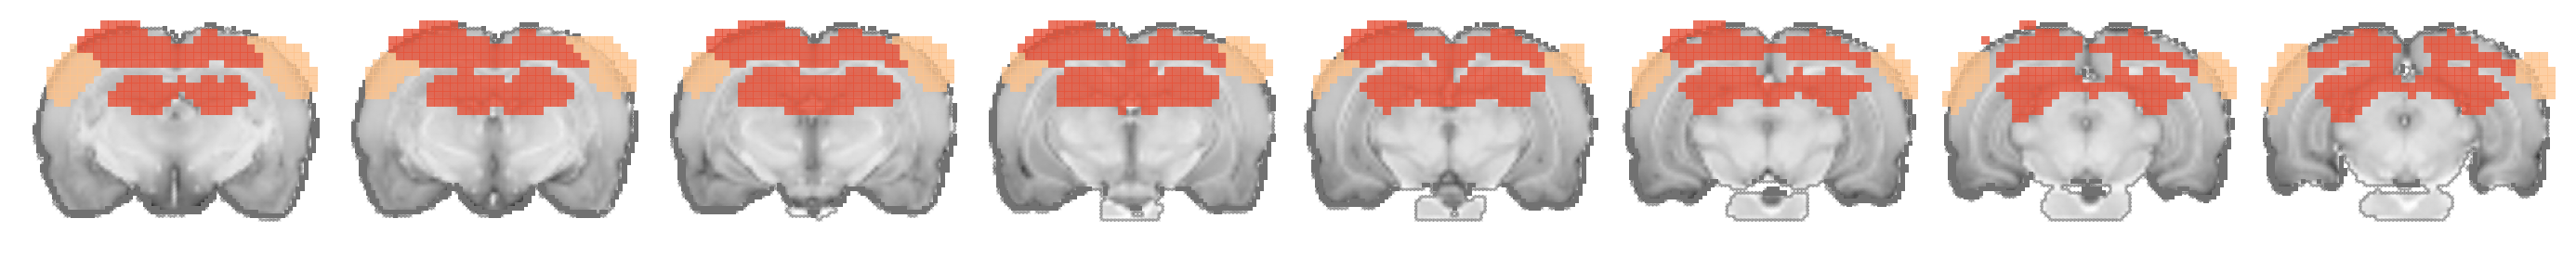

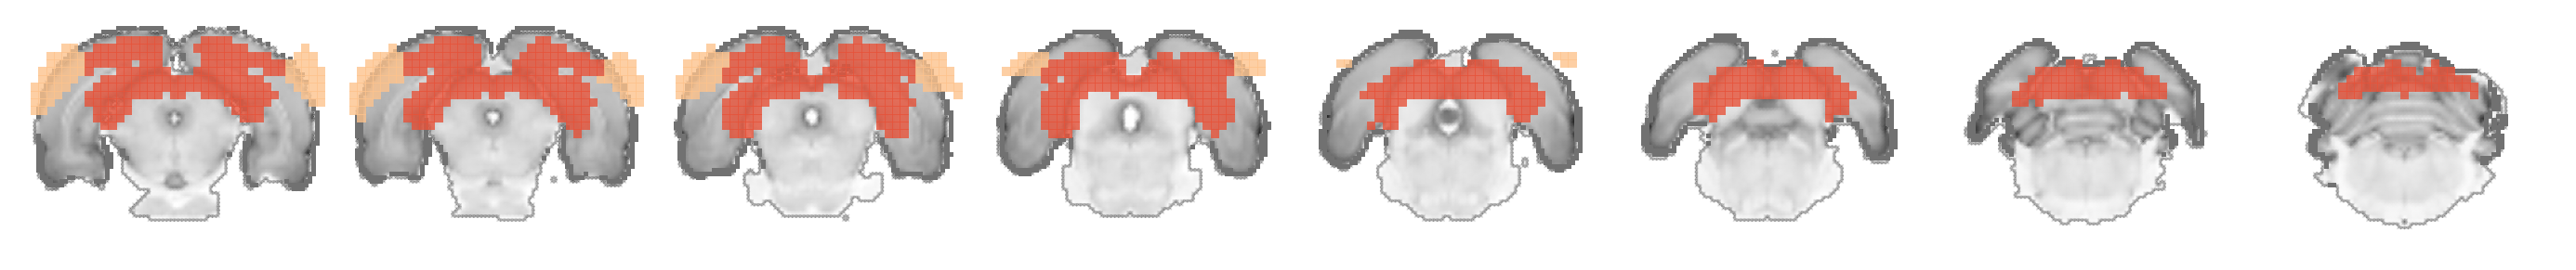

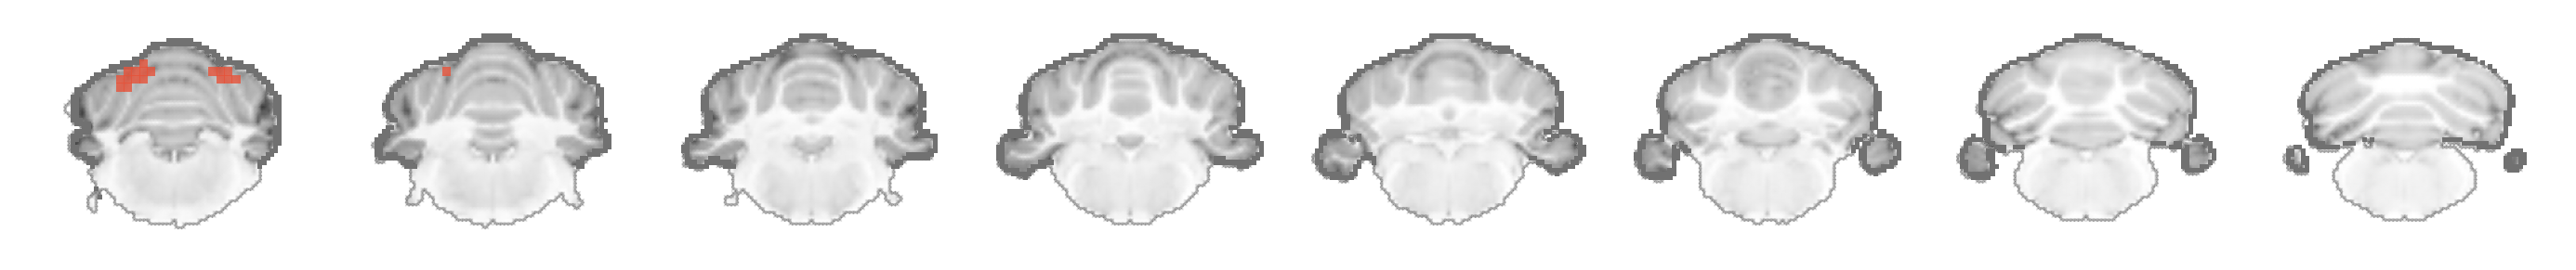

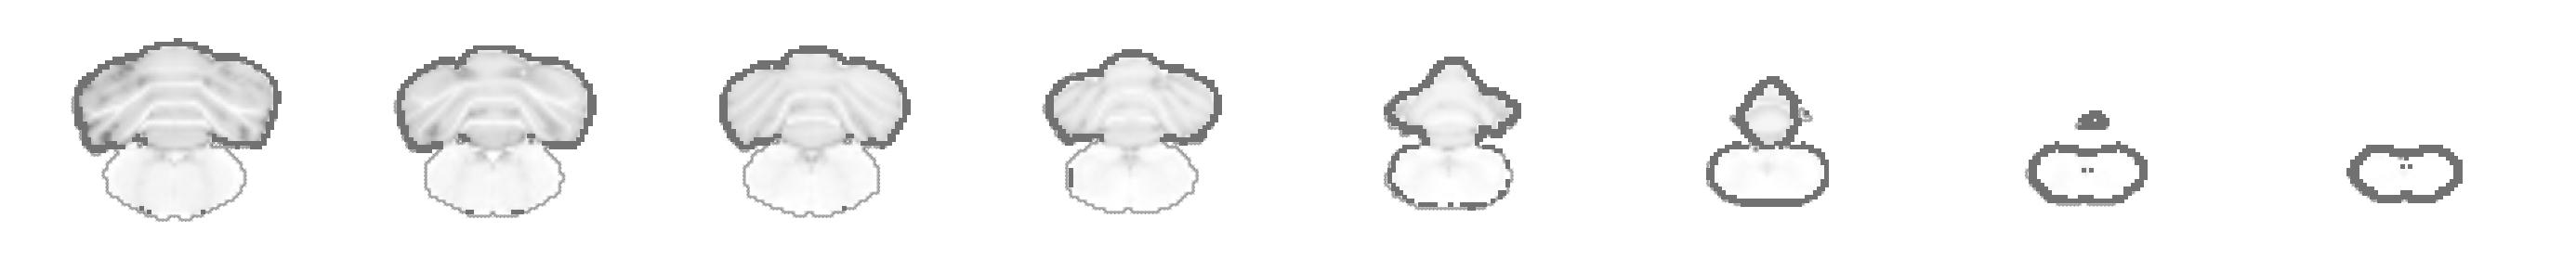

In [48]:
from custom_module import mosaicview_paxinos, crop_by_voxel, pad_by_voxel, norm_orient, correct_affine, thr_by_z, thr_by_voxelsize

anat_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'
anat_obj = nib.load(anat_path)
anat_obj = crop_by_voxel(pad_by_voxel(norm_orient(anat_obj), a=2), l=30, r=30)
anat_obj = correct_affine(anat_obj)

# func_obj = nib.load(rich_club_path)
func_obj = nib.load(rnh_path)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
func_obj = thr_by_z(func_obj, pval = 0.5)
# func_obj._dataobj = np.asarray(func_obj.dataobj).astype(bool).astype(int)
func_obj = thr_by_voxelsize(func_obj, 10)
func_obj = correct_affine(func_obj)

crag = 3
alpha = 0.8

affine = func_obj.affine.copy()
slice_coords = np.linspace(10.9, -17.5, 72)[4:-4] # All slices coordinates

for init in range(0, len(slice_coords), 8):
    selected_slices = slice_coords[np.arange(0, len(slice_coords), 1)][init:init+8]
    fig = mosaicview_paxinos(anat_obj, func_obj, selected_slices, dpi=300,
                             navi=False, annotate=False, vmin=0, vmax=crag, cmap='OrRd', alpha=alpha)

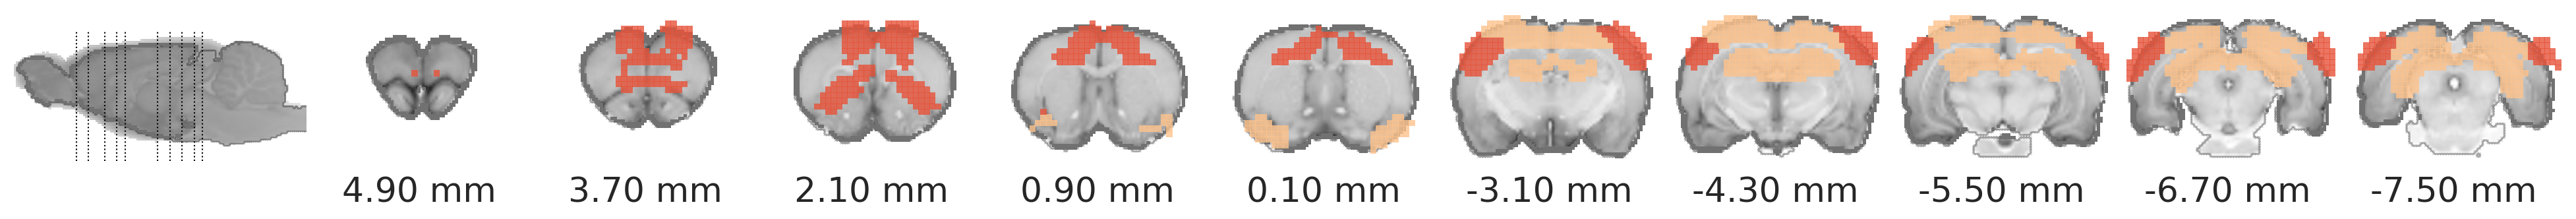

In [49]:
selected_slices = slice_coords[[11, 14, 18, 21, 23, 31, 34, 37, 40, 42]]
fig = mosaicview_paxinos(anat_obj, func_obj, selected_slices, dpi=300, 
                         navi=True, annotate=True, vmin=0, vmax=crag, alpha=alpha, fontsize=25, cmap='OrRd_r')

## Correlation resting-state functional organization structure between cohorts

In [117]:
from slfmri.lib.stats.ttest import ttest

dcode_dr = '40A'
dset_dr = pipe.get_dset(dcode_dr)

tested_subj = dict()
subj_id = 0
for _, finfo in dset_dr:
    subj = finfo.Subject
    if subj not in tested_subj.keys():
        tested_subj[subj] = subj_id
        subj_id += 1
        
meta_dict = dict(SubjectID=[], Sex=[], Strain=[], Idx=[])
subj_ptrn = r'sub-[A-Z]{3}(?P<Strain>[A-Z]{1})[0-9]{2}(?P<Sex>[A-Z]{1})'
for sub, idx in tested_subj.items():
    matched = re.match(subj_ptrn, sub)
    if matched:
        sex = matched.group('Sex')
        strain = matched.group('Strain')
        if sex != 'F':
            sex = 'M'
        meta_dict['SubjectID'].append(sub[4:]) 
        meta_dict['Sex'].append(sex)
        if 'HD' in sub:
            strain = 'B'
        if 'JB' in sub:
            strain = 'A'
        meta_dict['Strain'].append(strain)
        meta_dict['Idx'].append(idx)
    else:
        print(sub)
        
meta_df = pd.DataFrame(meta_dict)

list_subjs = meta_df['SubjectID'].unique()
group_ids = ['SD-M', 'SD-F', 'WT-M', 'WT-F', 'LE-M']
group_dict = dict()

for g in group_ids:
    if len(g.split('-')) == 2:
        scode, sex = g.split('-')
    else:
        scode = g
        sex = None
    if scode == 'SD':
        strain = 'A'
    elif scode == 'WT':
        strain = 'C'
    else:
        strain = 'B'
        
    if sex == None:
        sub_meta = meta_df.query('Strain==@strain')
    else:
        sub_meta = meta_df.query('Sex==@sex and Strain==@strain')
        
    sub_data = values[:, sub_meta['Idx'], :].mean(-1)
    avr_data, _, _ = ttest(sub_data, np.ones([sub_data.shape[1], 1]))
    group_dict[g] = dict(meta=sub_meta, data=avr_data[:, 0])

thr_value = thr_matrix.values[np.nonzero(np.tril(np.ones(thr_matrix.shape), k=-1))]
sig_mask = np.nonzero(thr_value)

group_comp = thr_value #[sig_mask]
columns = ['All']
for g, dc in group_dict.items():
    columns.append(g)
    group_comp = np.c_[group_comp, dc['data']] #[sig_mask]]
group_comp = pd.DataFrame(group_comp, columns=columns)

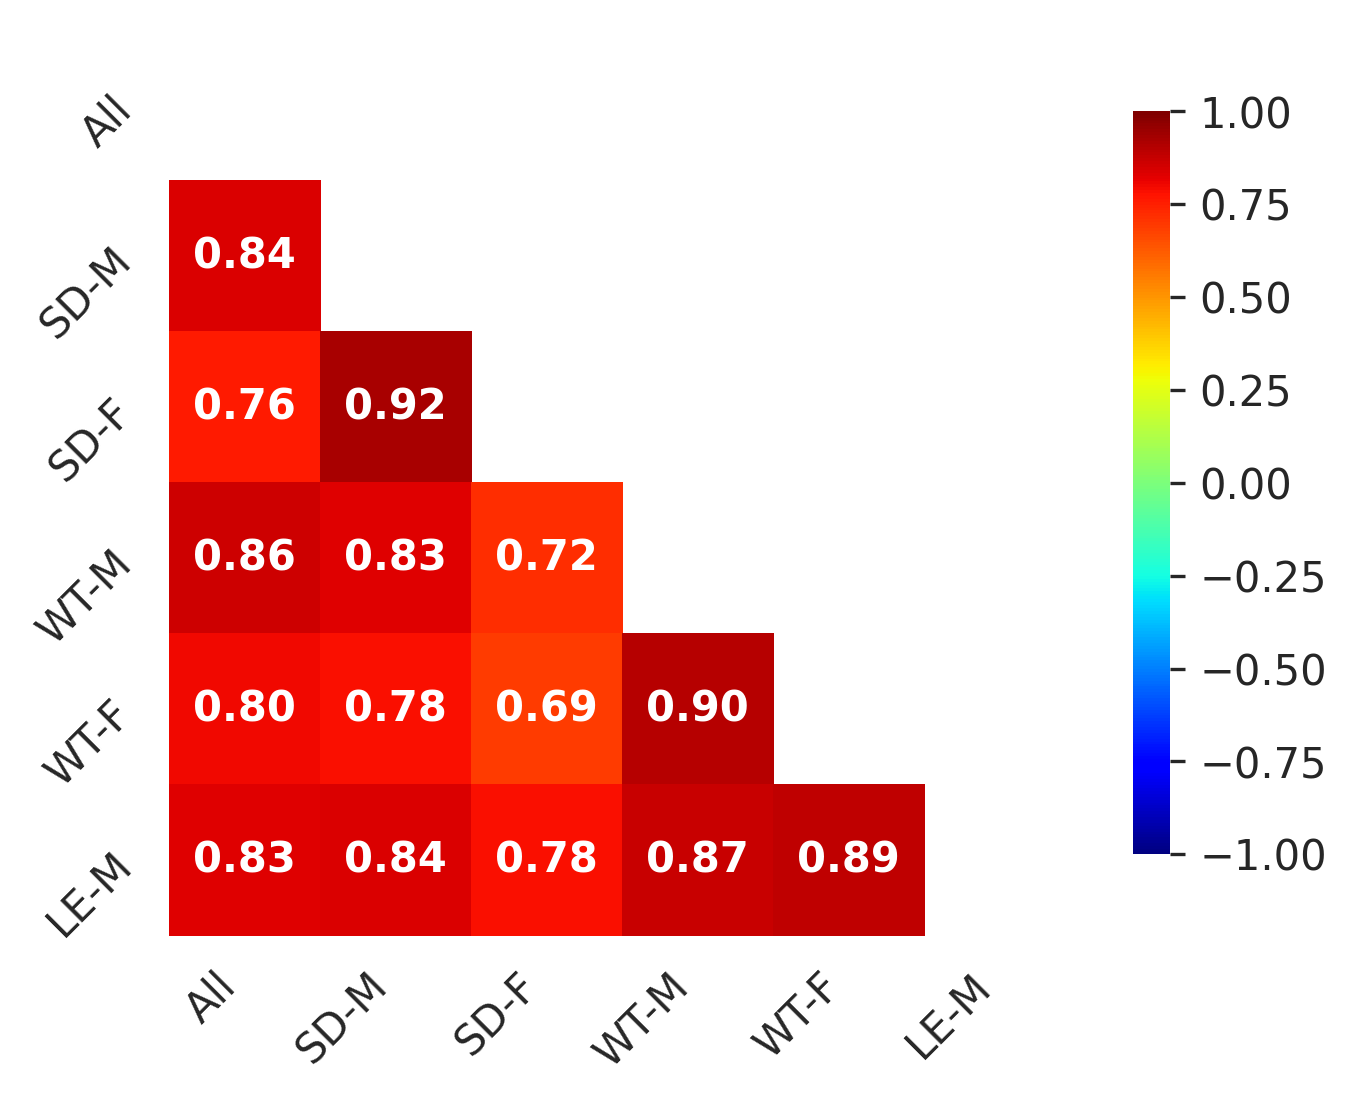

In [118]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4], dpi=300)
corr_arr = group_comp.corr().values
corr_arr[np.nonzero(np.triu(np.ones(corr_arr.shape)))] = np.nan
corr_mat = pd.DataFrame(corr_arr, columns=columns, index=columns)
hm = sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='jet', ax=ax, annot=True,
            cbar_kws={"shrink": .82}, fmt='.2f', annot_kws={"size": 10, "fontweight":'bold'},)
hm.set_yticklabels(hm.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')
hm.set_xticklabels(hm.get_xticklabels(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.set_aspect(1)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

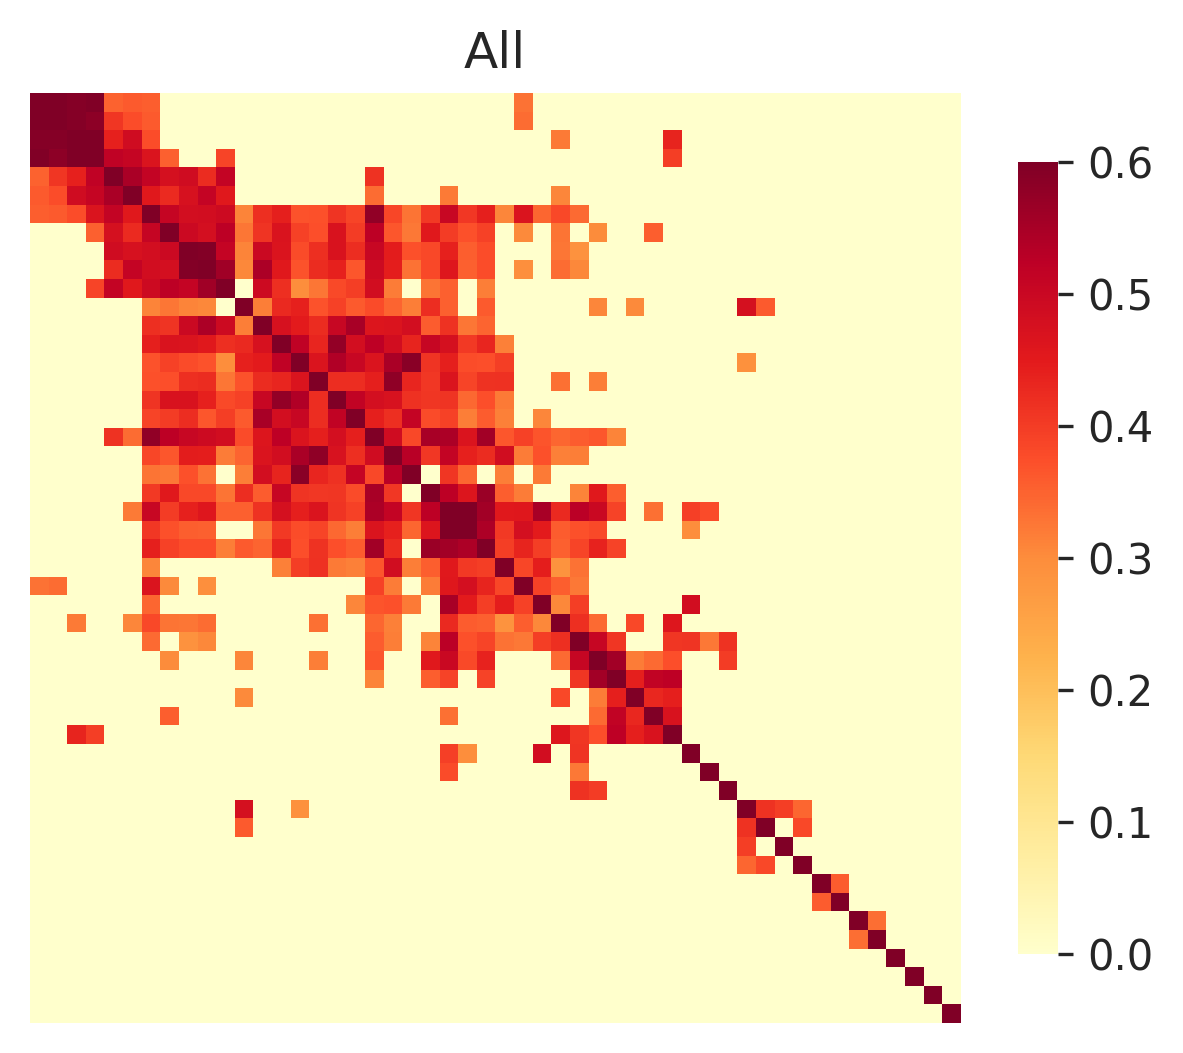

In [119]:
colors = copy.copy(mod_colors)
groups = copy.copy(mod_groups)
comcon = copy.copy(mod_comcon)

fig, ax = plt.subplots(1, 1, figsize=[5, 5], dpi=300)
ax.set_title('All')

hm = ax.imshow(new_mat, vmin=0, vmax=0.6, cmap='YlOrRd', interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_aspect(1)
ax.axis('off')

linewidth = 2
cax = plt.colorbar(hm, shrink=0.7)
cax.ax.tick_params(labelsize=10)
cax.outline.set_visible(False)

In [122]:
values.mean(-1).mean(-1)

array([0.8032, 0.1474, 0.056 , ..., 0.3017, 0.1944, 0.4339])

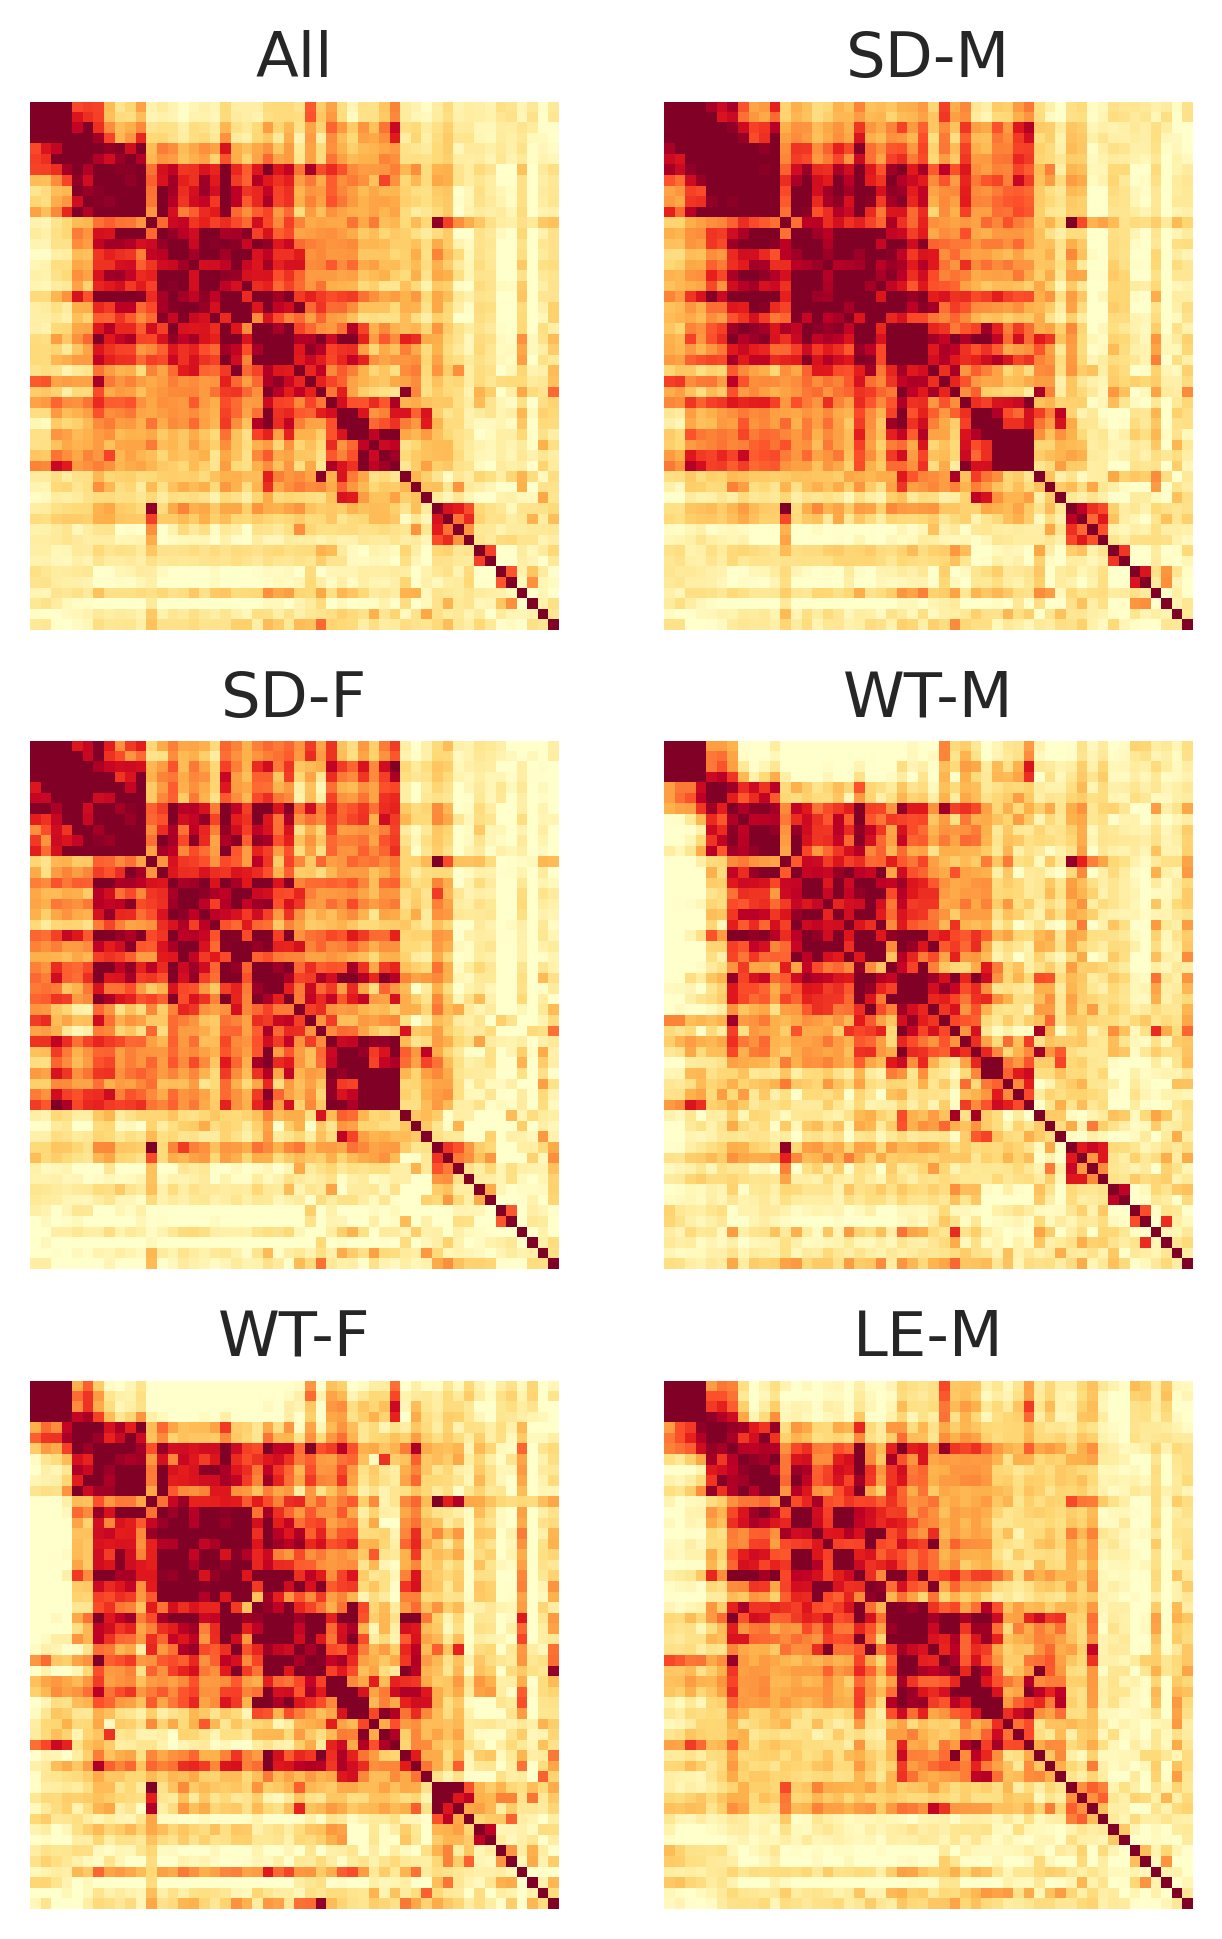

In [136]:
list_groups = ['All'] + list(np.array(list(group_dict.keys()))[[0, 1, 2, 3, 4]])
fig, axes = plt.subplots(3, 2, figsize=[5, 8], dpi=300)
axes = axes.flatten()

mat_labels = np.arange(1, thr_matrix.shape[0]+1)

for i, ax in enumerate(axes):
    g = list_groups[i]
    if i == 0:
        all_mat = np.zeros(thr_matrix.shape)
        half_msk = np.nonzero(np.tril(np.ones(all_mat.shape), k=-1))
        half_mat = all_mat[half_msk]
        half_mat = values.mean(-1).mean(-1)
        all_mat[half_msk] = half_mat
        all_mat += np.eye(all_mat.shape[0])
        all_mat += all_mat.T
        all_mat = pd.DataFrame(all_mat, columns=range(1, 51), index=range(1, 51))
        hm = ax.imshow(all_mat.loc[colm, colm], vmin=0, vmax=0.6, cmap='YlOrRd', interpolation='nearest')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect(1)
        ax.set_title(g, fontsize=15)
        ax.axis('off')
    else:
        
        ax.set_title(g, fontsize=15)
        ax.axis('off')

        subg_mat = np.zeros(thr_matrix.shape)
        half_msk = np.nonzero(np.tril(np.ones(subg_mat.shape), k=-1))
        half_mat = subg_mat[half_msk]
        half_mat = group_dict[g]['data']
#         half_mat[sig_mask] = group_dict[g]['data'][sig_mask]
        subg_mat[half_msk] = half_mat
        subg_mat += np.eye(output_matrix.shape[0])
        subg_mat += subg_mat.T
        subg_mat = pd.DataFrame(subg_mat, columns=mat_labels, index=mat_labels).loc[colm, colm]


        ax.imshow(subg_mat, vmin=0, vmax=0.6, cmap='YlOrRd', interpolation='nearest')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Networkx reference

To cite NetworkX please use the following publication:

Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

PDF BibTeX

The small-world coefficient of a graph G is:

omega = Lr/L - C/Cl

where C and L are respectively the average clustering coefficient and average shortest path length of G. Lr is the average shortest path length of an equivalent random graph and Cl is the average clustering coefficient of an equivalent lattice graph.

The small-world coefficient (omega) ranges between -1 and 1. Values close to 0 means the G features small-world characteristics. Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.

Notes

The implementation is adapted from the algorithm by Telesford et al. 1.

References

1
Telesford, Joyce, Hayasaka, Burdette, and Laurienti (2011). “The Ubiquity of Small-World Networks”. Brain Connectivity. 1 (0038): 367-75. PMC 3604768. PMID 22432451. doi:10.1089/brain.2011.0038.

In [38]:
g = matrix_to_graph(abs(thr_matrix))

In [39]:
idx = [i for i in thr_matrix.columns if i not in [39, 24, 46, 7, 48, 31, 6, 29]]

g = matrix_to_graph(abs(thr_matrix.loc[idx, idx]))

In [40]:
nx.degree_assortativity_coefficient(g)

0.22470990540600566

In [142]:
nx.smallworld.omega(g)

-0.3383257448813276

Returns the small-world coefficient (sigma) of the given graph.

The small-world coefficient is defined as: sigma = C/Cr / L/Lr where C and L are respectively the average clustering coefficient and average shortest path length of G. Cr and Lr are respectively the average clustering coefficient and average shortest path length of an equivalent random graph.

A graph is commonly classified as small-world if sigma>1.

The implementation is adapted from Humphries et al. 1 2.

References

1
The brainstem reticular formation is a small-world, not scale-free, network M. D. Humphries, K. Gurney and T. J. Prescott, Proc. Roy. Soc. B 2006 273, 503-511, doi:10.1098/rspb.2005.3354.

2
Humphries and Gurney (2008). “Network ‘Small-World-Ness’: A Quantitative Method for Determining Canonical Network Equivalence”. PLoS One. 3 (4). PMID 18446219. doi:10.1371/journal.pone.0002051.

In [143]:
nx.smallworld.sigma(g)

1.1868811727990976

In [116]:
num_frames = 0
for i, finfo in pipe.get_dset('func'):
    num_frames += nib.load(finfo.Abspath).shape[-1]
print(f'a total {num_frames} volumes')

a total 74201 volumes


In [32]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

cmap = {'royalblue': [50],
        'limegreen': [45, 38, 41, 30, 28, 13, 20, 3, 44, 43],
        'palevioletred': [37, 16, 34]}
atlas_obj = nib.load('../Results/UNCCH_CAMRI/140_Pacellation/Rat_CAMRI_400um_ATLAS-filtered_E.nii.gz')
atlas = np.asarray(atlas_obj.dataobj)

In [45]:
from custom_module import *
from slfmri import io as slio

def mosaicview_slice(anat_obj, func_obj, slice_coords, layer2=None, view='coronal', vmin=-5, vmax=5, navi=True
                     ,**kwargs):
    
    cmap = kwargs['cmap'] if 'cmap' in kwargs.keys() else 'coolwarm'
    alpha = kwargs['alpha'] if 'alpha' in kwargs.keys() else 1
    interpolation = kwargs['interpolation'] if 'interpolation' in kwargs.keys() else 'nearest'
    
    
    """ Incompleted code """
    import matplotlib.lines as mlines
    mpobj = get_maxproj(anat_obj)
    ah, am, aimg = mpobj[view]

    # nevigation axis
    nav_ref = dict(axial='sagittal', coronal='sagittal', sagittal='axial')
    slc_ref = dict(axial=np.array([0, 0, 1]),
                   coronal=np.array([0, 1, 0]),
                   sagittal=np.array([1, 0, 0]))

    anat_coords = [mm_to_voxel(slc_ref[view] * s, anat_obj.affine) for s in slice_coords]
    func_coords = [mm_to_voxel(slc_ref[view] * s, func_obj.affine) for s in slice_coords]

    mpobj = get_maxproj(anat_obj, sigma=2)
    slobj = get_slice(anat_obj, coord=mm_to_voxel([0, 0, 0], anat_obj.affine))
    _, _, rimg = mpobj[view]
    nh, nw, nimg = mpobj[nav_ref[view]]
    sh, sw, simg = slobj[nav_ref[view]]

    n_slices = len(slice_coords)
    n = rimg.shape[-1]
    
    if navi:
        m = rimg.shape[0] * n_slices + rimg.shape[1]
    else:
        m = rimg.shape[0] * n_slices
        
    if m < n:
        figsize = [m/m, n/m]
    else:
        figsize = [m/n, n/n]
        
    figsize = np.array(figsize) * 3

    fig = plt.figure(constrained_layout=False, dpi=150, figsize=figsize)
    
    if navi:
        gs = fig.add_gridspec(nrows=1, ncols=n_slices + 1, 
                              left=0, right=1, wspace=0, hspace=0, 
                              width_ratios=[rimg.shape[1]/rimg.shape[0]] + [1]*n_slices,
                              height_ratios=[1])

        nev_ax = fig.add_subplot(gs[0, 0])
        nev_ax.pcolormesh(nh, nw, nimg, cmap='Greys', vmin=-10000, vmax=60000)
        nev_ax.pcolormesh(sh, sw, simg, cmap='binary', vmin=-30000, vmax=80000, shading='gouraud')
        nev_ax.pcolormesh(nh, nw, get_outline(simg), cmap='binary', alpha=1, vmin=0, vmax=1.8)
        nev_ax.set_aspect(1)
        nev_ax.invert_xaxis()
        nev_ax.axis('off')
        ymin, ymax = nev_ax.get_ylim()
        for sc in slice_coords:
            l = mlines.Line2D([sc, sc], [ymin, ymax],
                              linestyle=':', linewidth=1, color='black')
            nev_ax.add_line(l)
    else:
        gs = fig.add_gridspec(nrows=1, ncols=n_slices, 
                              left=0, right=1, wspace=0, hspace=0, 
                              width_ratios=[1]*n_slices)
    for i, s in enumerate(anat_coords):
        # slice axis
        ax = fig.add_subplot(gs[0, i + navi])
        slc_img = get_slice(anat_obj, coord=s)
        fnc_img = get_slice(func_obj, coord=func_coords[i])
        anat_h, anat_w, anat_img = slc_img[view]
        func_h, func_w, func_img = fnc_img[view]
        func_img[func_img == 0] = np.nan
        
        if layer2:
            ly2_img = get_slice(layer2, coord=func_coords[i])
            ly2_h, ly2_w, ly2_img = ly2_img[view]
            ly2_img[ly2_img == 0] = np.nan
        
        ax.pcolormesh(anat_h, anat_w, anat_img, cmap='Greys', vmin=7000, vmax=30000, shading='gouraud')
        ax.pcolormesh(anat_h, anat_w, get_outline(anat_img), cmap='binary', alpha=1, vmin=0, vmax=1.8)
        if layer2:
            ax.pcolormesh(func_h, func_w, func_img, cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
            ax.pcolormesh(ly2_h, ly2_w, ly2_img, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        else:
            ax.pcolormesh(func_h, func_w, func_img, cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
            
        ax.set_aspect(1)
        ax.axis('off')
    return fig

def mosaicview_paxinos(anat_obj, func_obj, coord, layer2=None, navi=True, annotate=True, 
                       vmin=-5, vmax=5, cmap='coolwarm', fontsize=15, **kwargs):
    slice_coords = np.array(coord) + 0.36
    fig = mosaicview_slice(anat_obj, func_obj, slice_coords, layer2=layer2, view='coronal', vmin=vmin, vmax=vmax, 
                           navi=navi, cmap=cmap, **kwargs)

    if annotate:
        for i, ax in enumerate(fig.get_axes()):
            if navi:
                if i != 0:
                    xmin, xmax = ax.get_xlim()
                    ymin, ymax = ax.get_ylim()
                    ax.text((xmin + xmax)/2, ymin - 2, f'{coord[i-1]:.2f} mm', 
                            horizontalalignment='center',
                            verticalalignment='bottom',
                            fontsize=fontsize)
            else:
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
                ax.text((xmin + xmax)/2, ymin - 2, f'{coord[i]:.2f} mm', 
                        horizontalalignment='center',
                        verticalalignment='bottom',
                        fontsize=fontsize)
    return fig

In [50]:
cmap1 = {'royalblue': [11, 2, 36, 1, 32, 23, 50],
         'limegreen': [45, 38, 41, 33, 30, 28, 13, 20, 40, 3, 49, 44, 43, 9, 22],
         'palevioletred': [37, 27, 16, 10, 12, 26, 14, 34, 47, 4, 42, 19, 15, 8, 17, 18]}

cmap2 = {'royalblue': [50],
        'limegreen': [45, 38, 41, 30, 28, 13, 20, 3, 44, 43],
        'palevioletred': [37, 16, 34]}

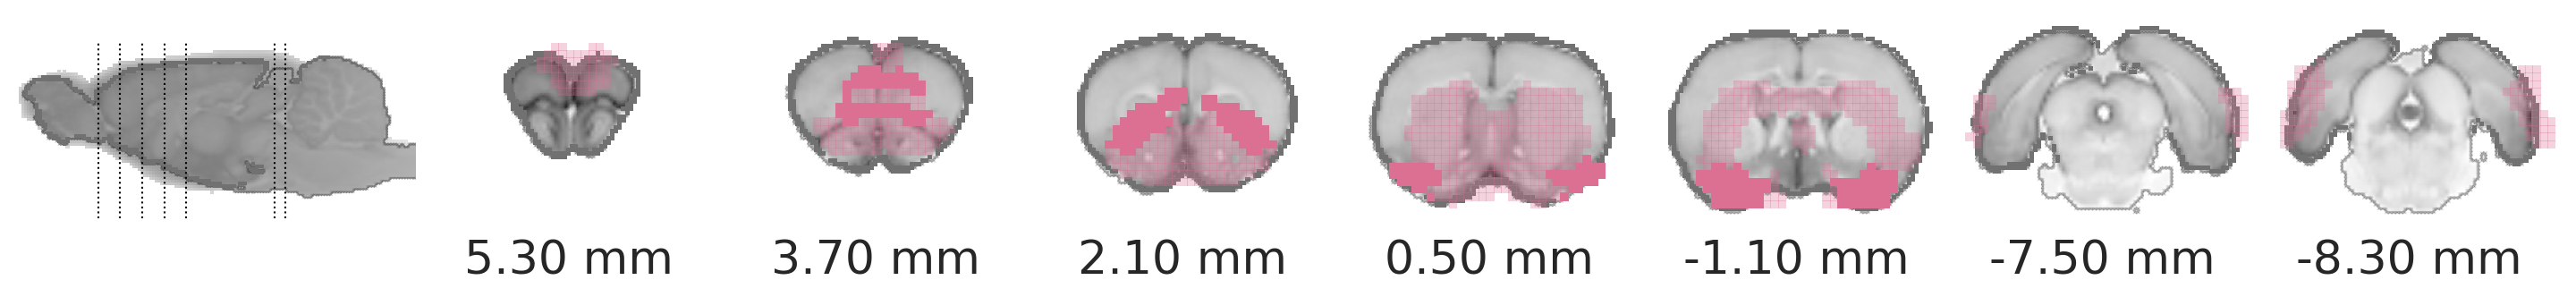

In [62]:
net_color = 'palevioletred'
func_obj1 = np.zeros(atlas.shape)

for i in cmap1[net_color]:
    func_obj1[atlas == i] = 1
    
func_obj1 = nib.Nifti1Image(func_obj1, atlas_obj.affine)
func_obj2 = np.zeros(atlas.shape)

for i in cmap2[net_color]:
    func_obj2[atlas == i] = 1
    
func_obj2 = nib.Nifti1Image(func_obj2, atlas_obj.affine)

color_set = ['black', net_color]
n_bin = len(color_set)
pallete = LinearSegmentedColormap.from_list('network', color_set, N=n_bin)
slice_coords = np.linspace(10.9, -17.9, 37)[2:-2] # All slices coordinates
selected_coords = slice_coords[[5, 7, 9, 11, 13, 21, 22]]

anat_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'
anat_obj = nib.load(anat_path)
anat_obj = crop_by_voxel(pad_by_voxel(norm_orient(anat_obj), a=2), l=30, r=30)
anat_obj = correct_affine(anat_obj)
func_obj1 = crop_by_voxel(pad_by_voxel(norm_orient(func_obj1), a=1), l=15, r=15)
func_obj1 = correct_affine(func_obj1)
func_obj2 = crop_by_voxel(pad_by_voxel(norm_orient(func_obj2), a=1), l=15, r=15)
func_obj2 = correct_affine(func_obj2)


fig = mosaicview_paxinos(anat_obj, func_obj1, selected_coords, layer2=func_obj2, dpi=300, 
                         navi=True, annotate=True, vmin=0, vmax=1, 
                         alpha=0.3, fontsize=25, cmap=pallete)

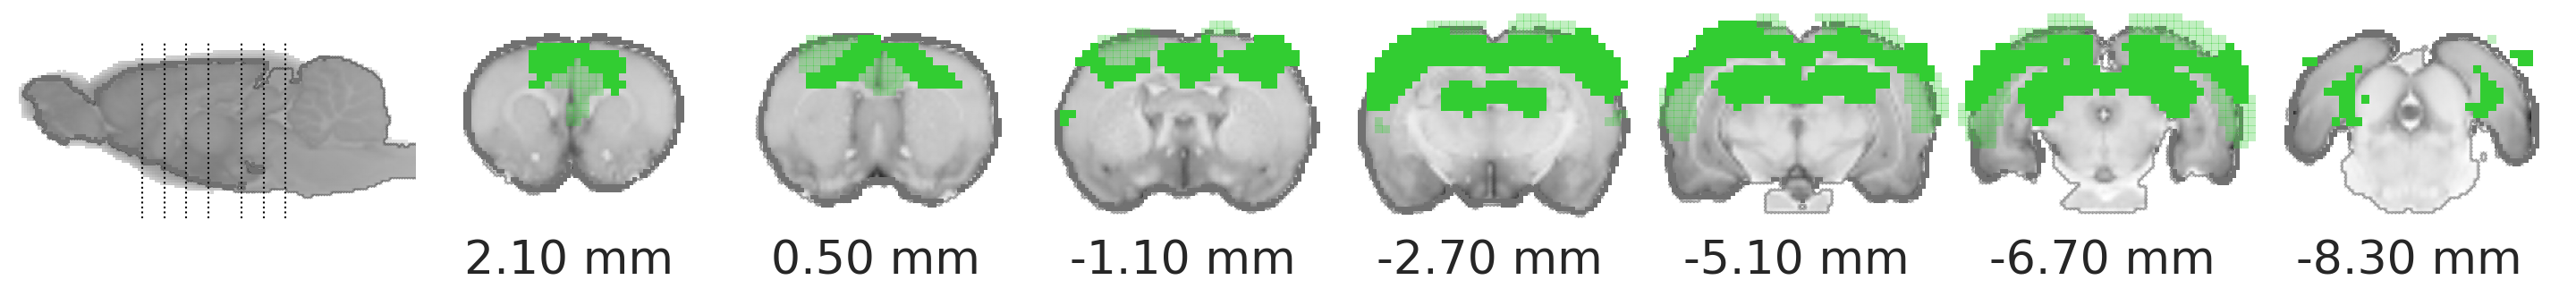

In [60]:
net_color = 'limegreen'
func_obj1 = np.zeros(atlas.shape)

for i in cmap1[net_color]:
    func_obj1[atlas == i] = 1
    
func_obj1 = nib.Nifti1Image(func_obj1, atlas_obj.affine)
func_obj2 = np.zeros(atlas.shape)

for i in cmap2[net_color]:
    func_obj2[atlas == i] = 1
    
func_obj2 = nib.Nifti1Image(func_obj2, atlas_obj.affine)

color_set = ['black', net_color]
n_bin = len(color_set)
pallete = LinearSegmentedColormap.from_list('network', color_set, N=n_bin)
slice_coords = np.linspace(10.9, -17.9, 37)[2:-2] # All slices coordinates
selected_coords = slice_coords[[9, 11, 13, 15, 18, 20, 22]]
# slice_coords = np.linspace(10.9, -17.5, 72)[4:-4]
# selected_coords = slice_coords[[11, 14, 18, 21, 23, 31, 34, 37, 40, 42]]
anat_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'
anat_obj = nib.load(anat_path)
anat_obj = crop_by_voxel(pad_by_voxel(norm_orient(anat_obj), a=2), l=30, r=30)
anat_obj = correct_affine(anat_obj)
func_obj1 = crop_by_voxel(pad_by_voxel(norm_orient(func_obj1), a=1), l=15, r=15)
func_obj1 = correct_affine(func_obj1)
func_obj2 = crop_by_voxel(pad_by_voxel(norm_orient(func_obj2), a=1), l=15, r=15)
func_obj2 = correct_affine(func_obj2)


fig = mosaicview_paxinos(anat_obj, func_obj1, selected_coords, layer2=func_obj2, dpi=300, 
                         navi=True, annotate=True, vmin=0, vmax=1, 
                         alpha=0.3, fontsize=25, cmap=pallete)

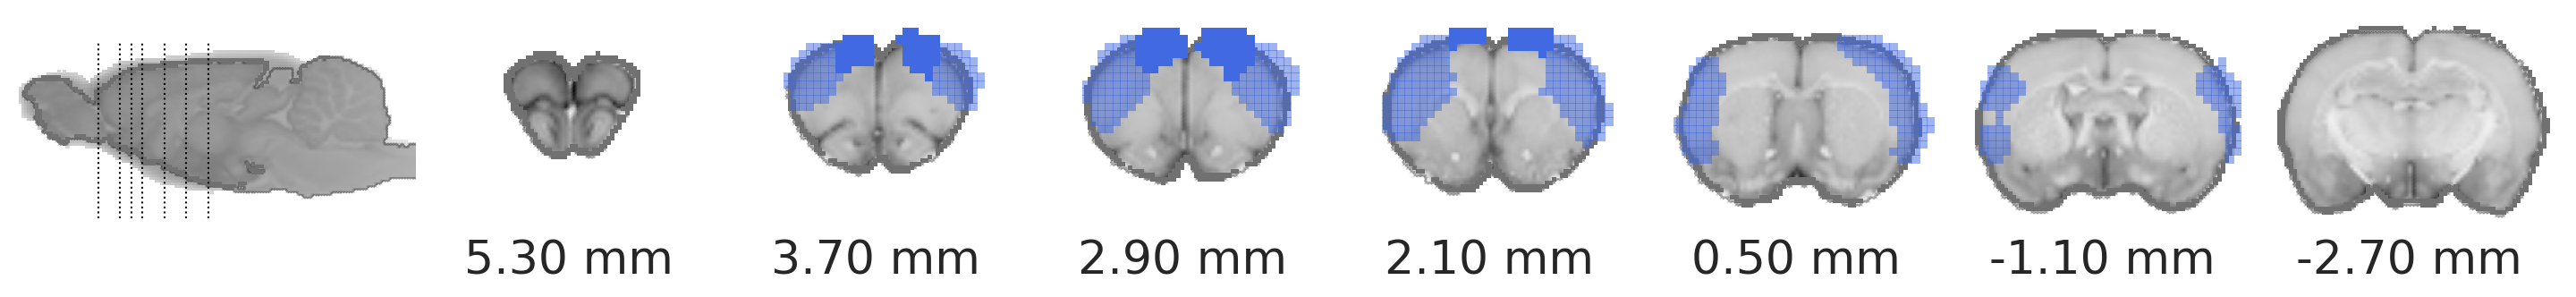

In [61]:
net_color = 'royalblue'
func_obj1 = np.zeros(atlas.shape)

for i in cmap1[net_color]:
    func_obj1[atlas == i] = 1
    
func_obj1 = nib.Nifti1Image(func_obj1, atlas_obj.affine)
func_obj2 = np.zeros(atlas.shape)

for i in cmap2[net_color]:
    func_obj2[atlas == i] = 1
    
func_obj2 = nib.Nifti1Image(func_obj2, atlas_obj.affine)

color_set = ['black', net_color]
n_bin = len(color_set)
pallete = LinearSegmentedColormap.from_list('network', color_set, N=n_bin)
slice_coords = np.linspace(10.9, -17.9, 37)[2:-2] # All slices coordinates
selected_coords = slice_coords[[5, 7, 8, 9, 11, 13, 15]]

anat_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'
anat_obj = nib.load(anat_path)
anat_obj = crop_by_voxel(pad_by_voxel(norm_orient(anat_obj), a=2), l=30, r=30)
anat_obj = correct_affine(anat_obj)
func_obj1 = crop_by_voxel(pad_by_voxel(norm_orient(func_obj1), a=1), l=15, r=15)
func_obj1 = correct_affine(func_obj1)
func_obj2 = crop_by_voxel(pad_by_voxel(norm_orient(func_obj2), a=1), l=15, r=15)
func_obj2 = correct_affine(func_obj2)


fig = mosaicview_paxinos(anat_obj, func_obj1, selected_coords, layer2=func_obj2, dpi=300, 
                         navi=True, annotate=True, vmin=0, vmax=1, 
                         alpha=0.5, fontsize=25, cmap=pallete)